#### Load momemta results

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

momemta_out = np.loadtxt('weights_clean.csv', delimiter=",")
benchmarks = momemta_out[0,:]
n_benchmarks = benchmarks.shape[0]
momemta_weights = momemta_out[1:,:]
n_events = momemta_weights.shape[0]
expected_benchmark_idx = 12
top_width = 1.5
print 'expected benchmark: {}'.format(benchmarks[expected_benchmark_idx])
print benchmarks.shape, momemta_weights.shape

expected benchmark: 172.0
(26,) (300, 26)


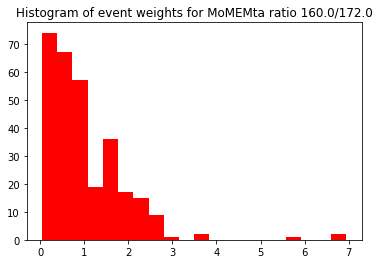

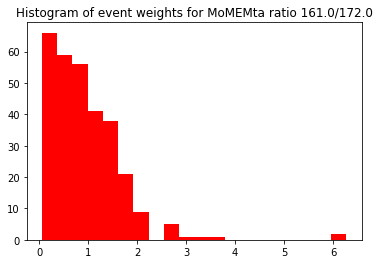

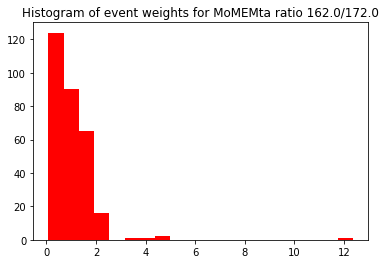

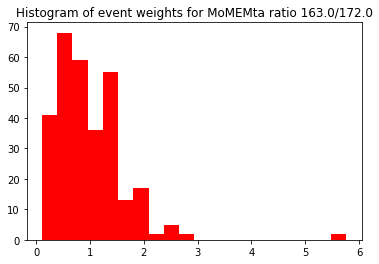

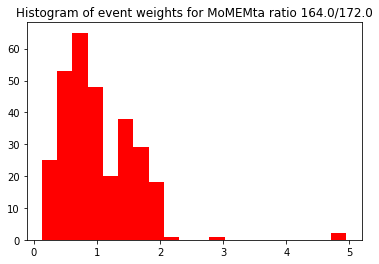

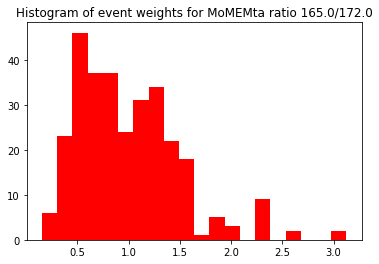

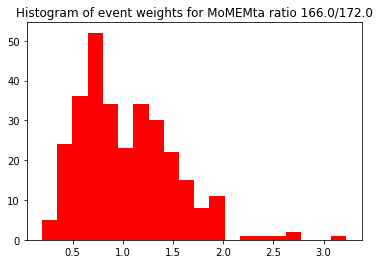

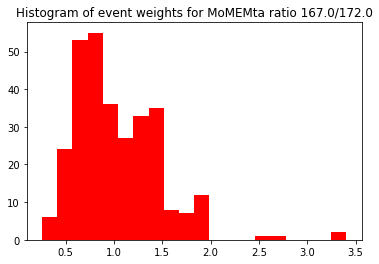

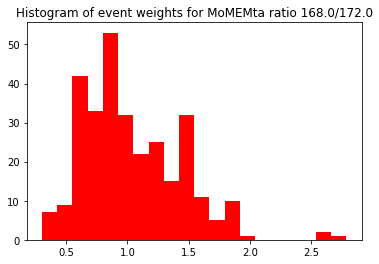

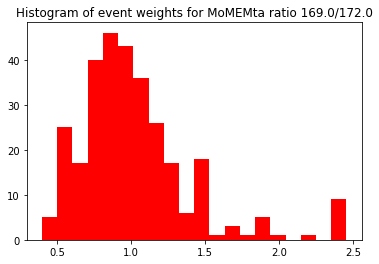

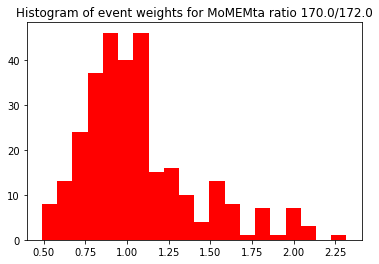

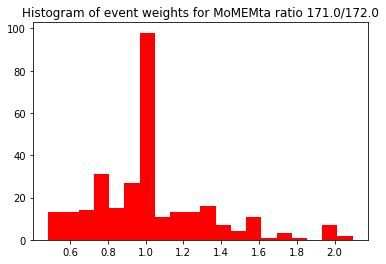

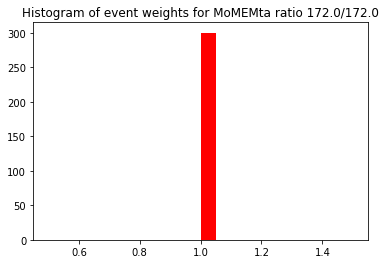

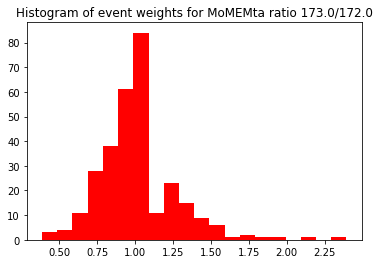

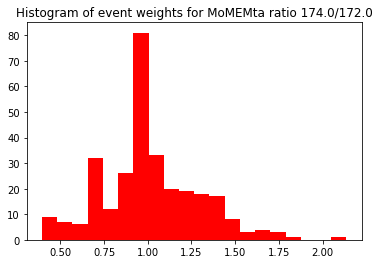

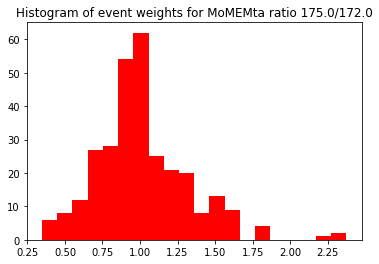

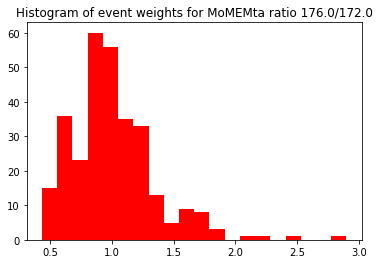

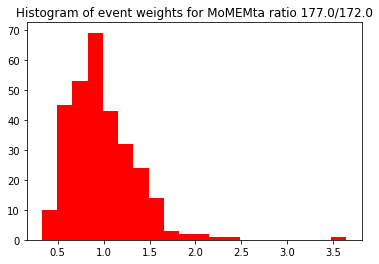

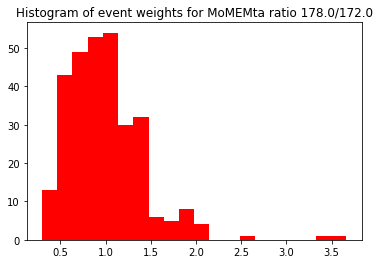

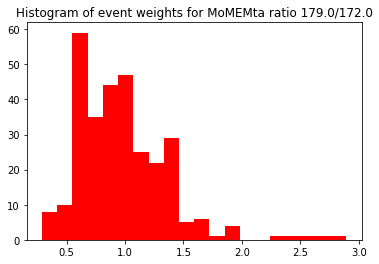

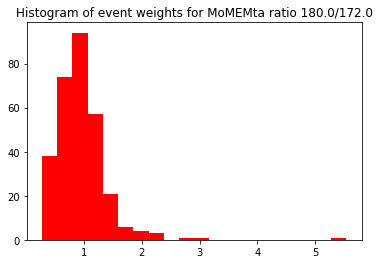

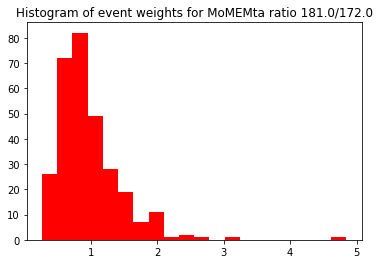

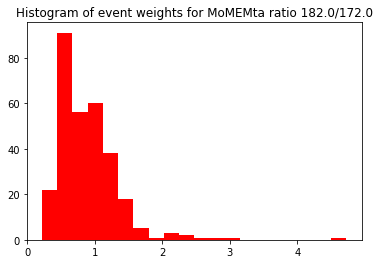

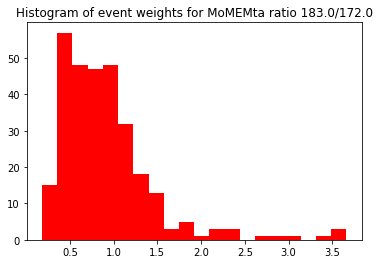

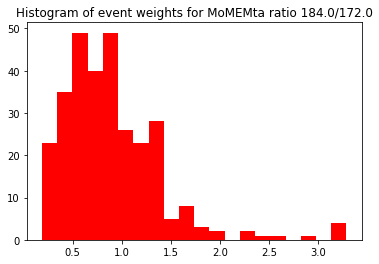

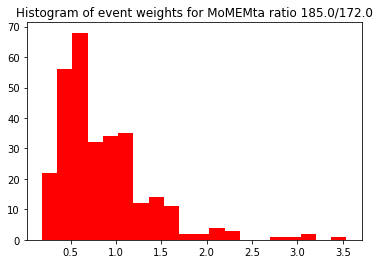

In [2]:
momemta_ratios = []
for event_weights in momemta_weights:
    momemta_ratios.append(event_weights/event_weights[expected_benchmark_idx])
momemta_ratios = np.array(momemta_ratios)

for idx, benchmark in enumerate(benchmarks):
    plt.hist(momemta_ratios[:,idx],bins=20, color='red')
    plt.title('Histogram of event weights for MoMEMta ratio {}/{}'.format(benchmarks[idx], benchmarks[expected_benchmark_idx]))
    plt.show()

In [3]:
momemta_log_sq_ratios = []
momemta_log_ratios = []
for ratio in momemta_ratios:
    momemta_log_ratios.append(np.log(ratio))
    momemta_log_sq_ratios.append(-2 * np.log(ratio))
    
momemta_log_ratios = np.array(momemta_log_ratios)
momemta_log_sq_ratios = np.array(momemta_log_sq_ratios)

print momemta_log_sq_ratios[0][0], momemta_log_sq_ratios[0][expected_benchmark_idx], momemta_log_sq_ratios[0][-1]

1.0311297030457176 -0.0 0.4297093538101002


In [4]:
momemta_sum_log_sq_ratios = np.sum(momemta_log_sq_ratios, axis=0)
print momemta_sum_log_sq_ratios

[205.32210206 188.6780648  149.11968307 116.64909177  84.7152775
  69.94176269  37.36236836  37.55495877  20.06210487  21.59780267
 -10.97364406   8.15336273   0.          10.07329405  14.54785979
  15.88332807  25.8322458   44.15005541  43.58441388  63.22869701
  85.2818595   81.36118967 128.69334534 133.16319826 147.08448078
 176.9391438 ]


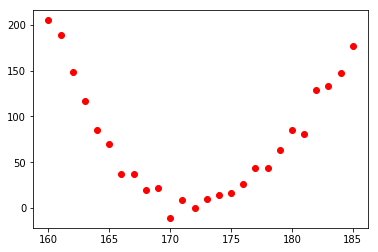

In [5]:
plt.plot(benchmarks, momemta_sum_log_sq_ratios, 'o', color='red');

#### Load madminer model and extract event-level ratios

In [6]:
from madminer.ml import ParameterizedRatioEstimator

In [7]:
forge = ParameterizedRatioEstimator(n_hidden=(100, 100))
forge.load('/home/zbhatti/codebase/madminer/momemta/inputs/alice')
theta0 = np.vstack( (np.linspace(benchmarks[0], benchmarks[-1], n_benchmarks), top_width*np.ones(n_benchmarks)) ).T
x = np.load('/home/zbhatti/codebase/madminer/momemta/inputs/x_test.npy')[:n_events,:]
log_ratios_T, _0 = forge.evaluate_log_likelihood_ratio(x=x, theta=theta0, test_all_combinations=True, run_on_gpu=False)
n_observables = x.shape[1]
print theta0.shape, x.shape, log_ratios_T.shape

(26, 2) (300, 23) (26, 300)


[187.59268    156.95001    128.73703    103.08225     80.10991
  59.92952     42.625156    28.248873    16.814934     8.30121
   2.6501737   -0.22534418  -0.43722486   1.8832917    6.590454
  13.52764     22.529896    33.426216    46.041485    60.19939
  75.72397     92.443344   110.19197    128.8144     148.16687
 168.11803   ]


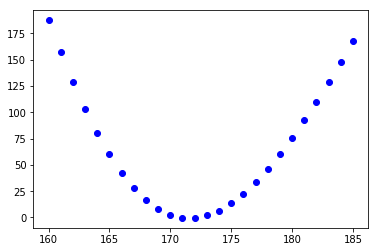

In [8]:
madminer_log_ratios = log_ratios_T.T
madminer_log_sq_ratios = -2*madminer_log_ratios
madminer_sum_log_sq_ratios = np.sum(-2*madminer_log_ratios, axis=0)
print madminer_sum_log_sq_ratios
plt.plot(benchmarks, madminer_sum_log_sq_ratios, 'o', color='blue')


In [9]:
madminer_log_ratios.shape, momemta_log_ratios.shape

((300, 26), (300, 26))

# Comparing madminer with MoMEMta

### compare all events with all bechmarks

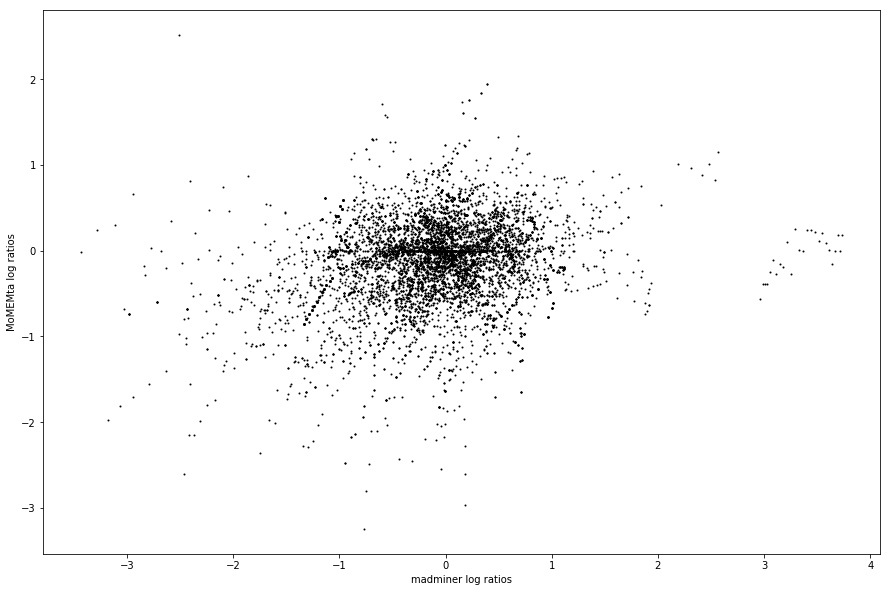

In [10]:
plt.figure(figsize=(15,10))
plt.scatter(madminer_log_ratios, momemta_log_ratios, marker='o', color='black', s=1);
plt.xlabel('madminer log ratios')
plt.ylabel('MoMEMta log ratios')
plt.show()

### compare each event for all benchmarks

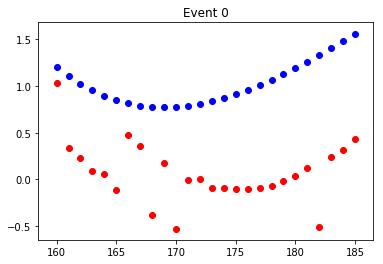

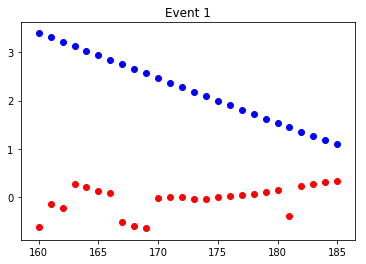

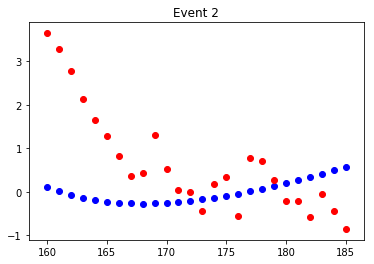

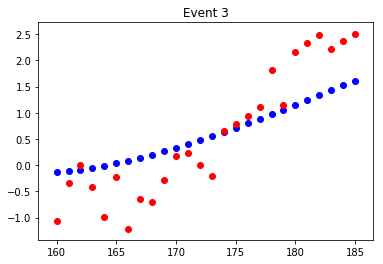

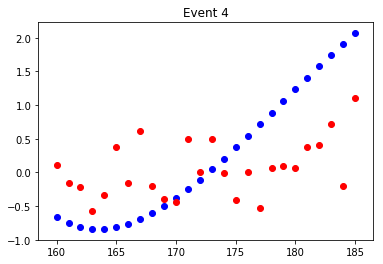

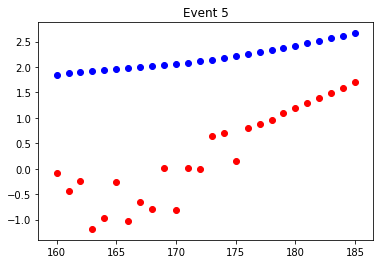

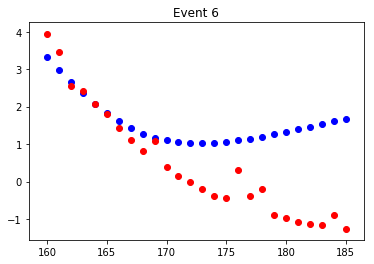

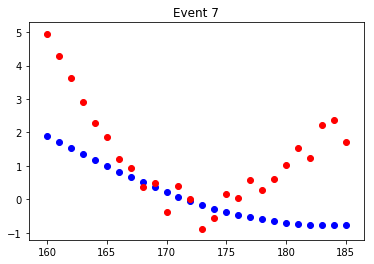

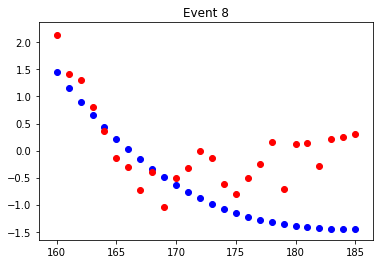

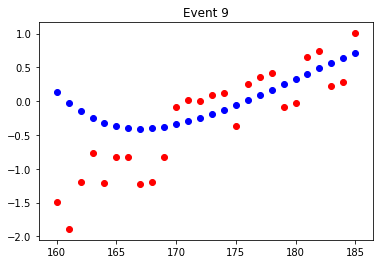

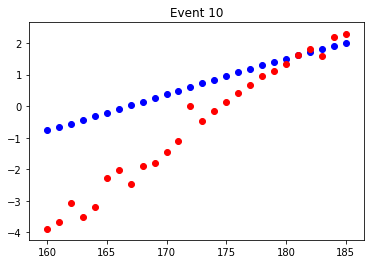

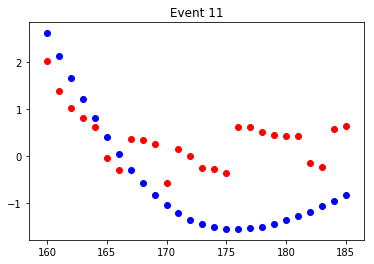

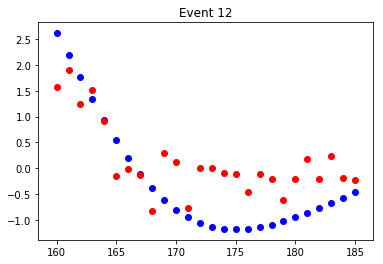

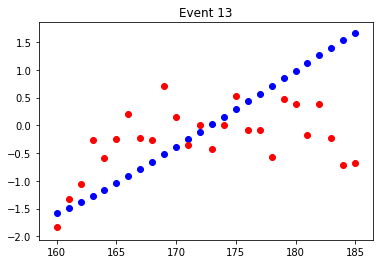

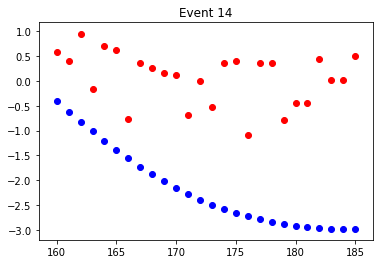

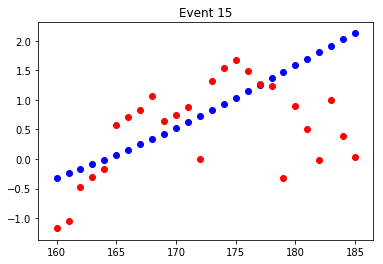

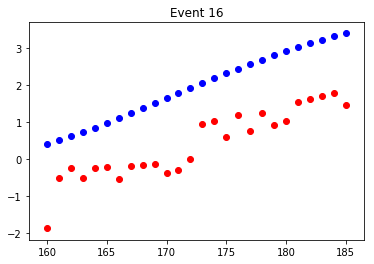

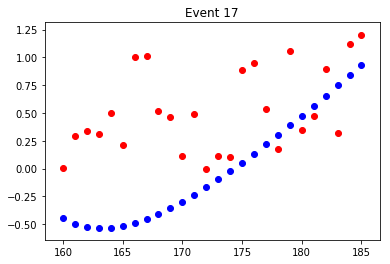

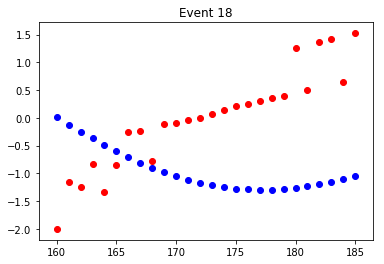

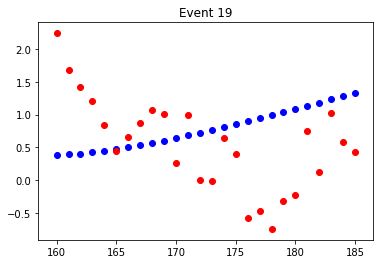

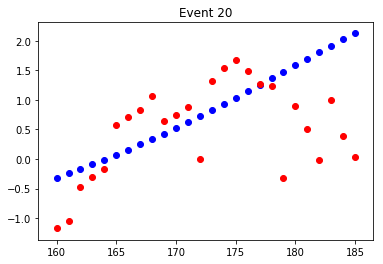

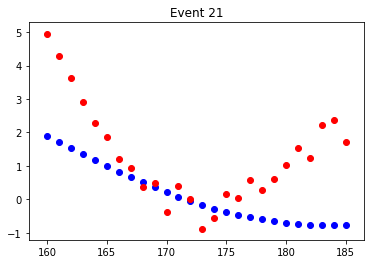

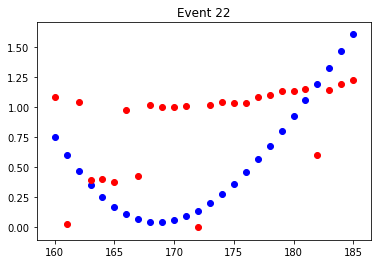

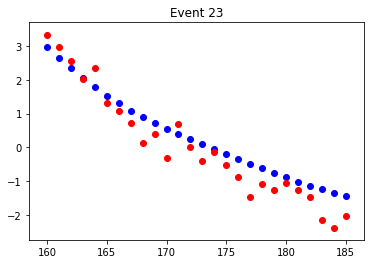

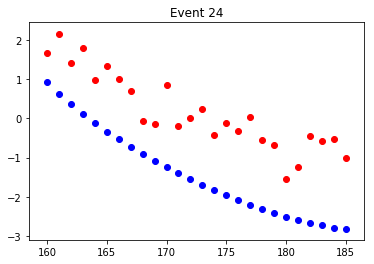

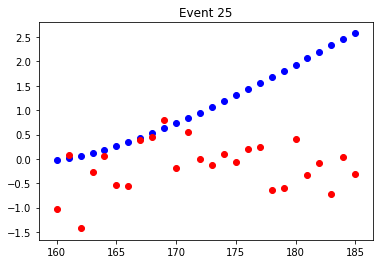

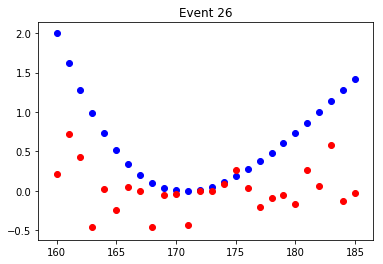

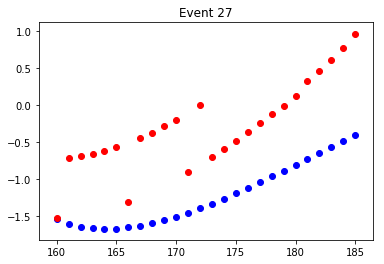

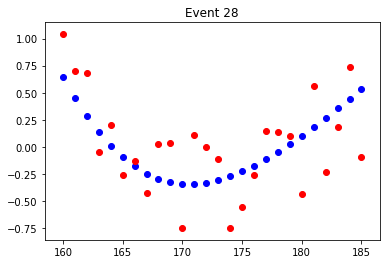

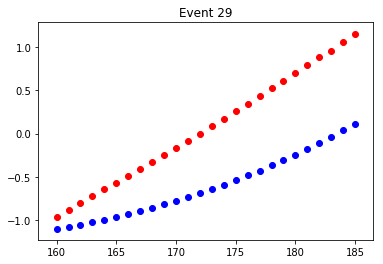

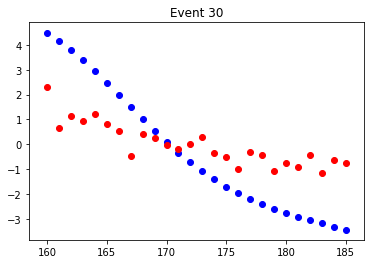

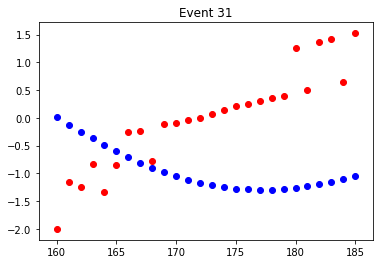

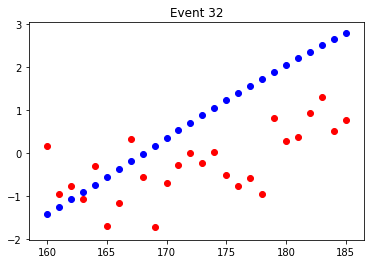

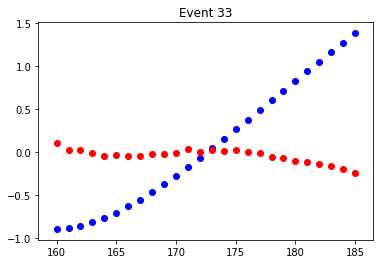

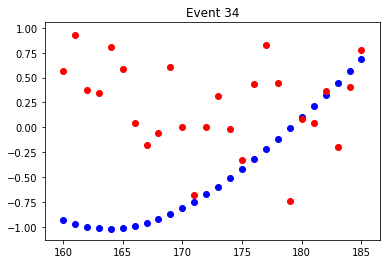

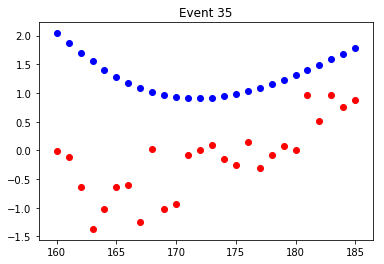

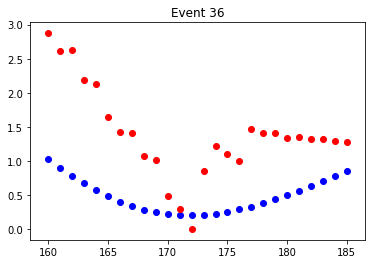

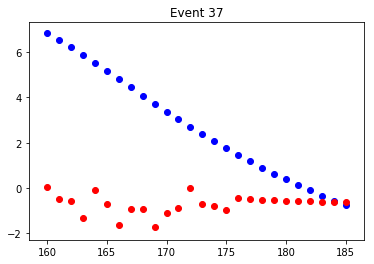

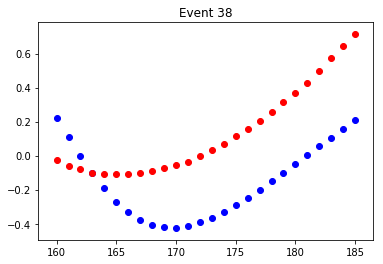

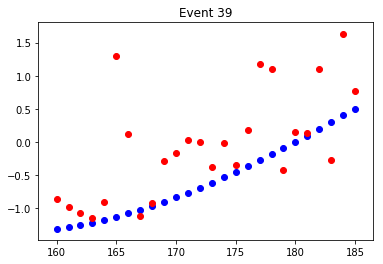

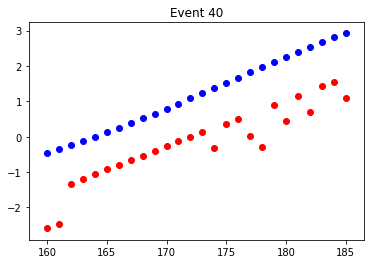

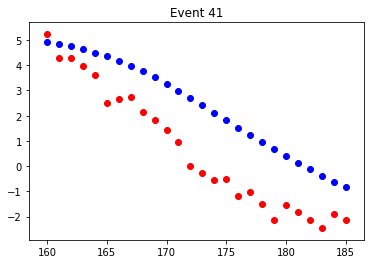

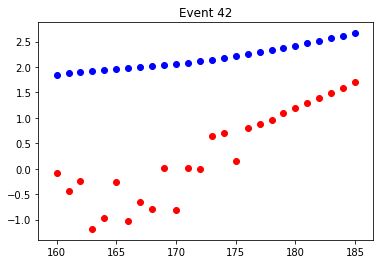

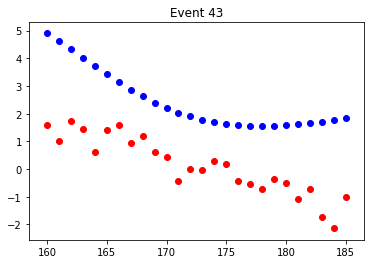

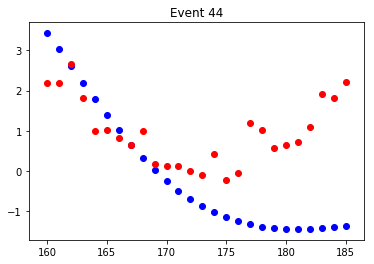

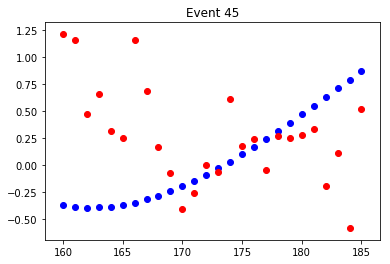

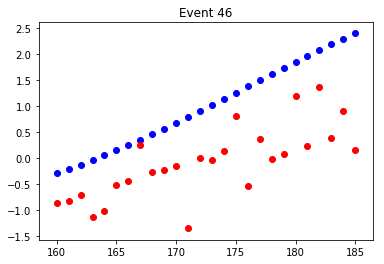

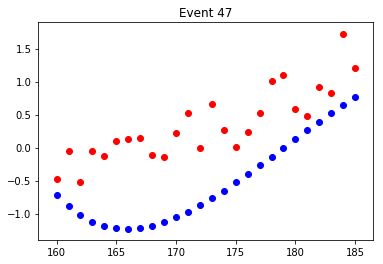

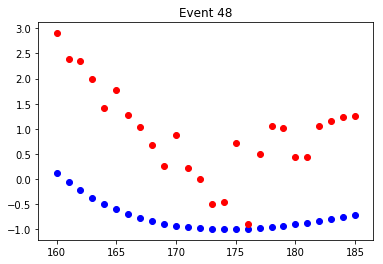

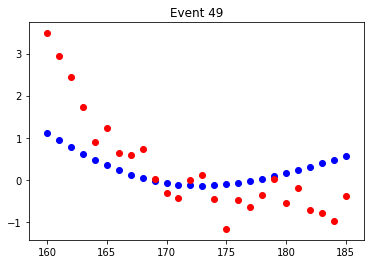

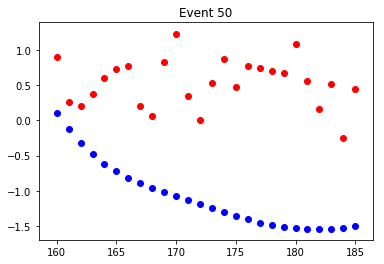

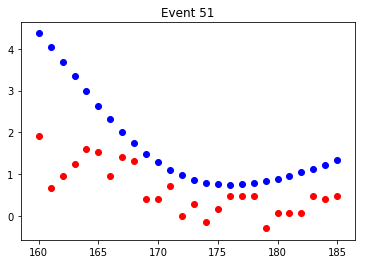

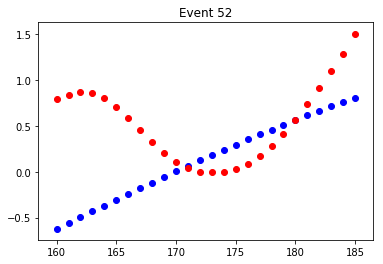

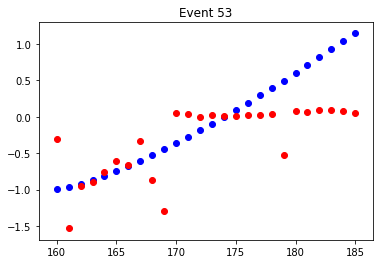

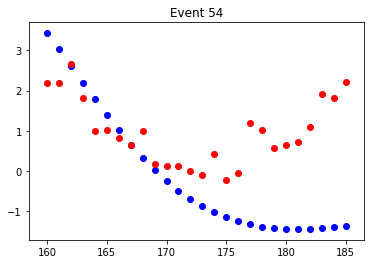

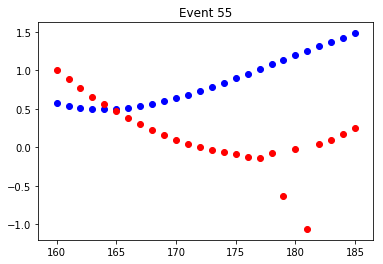

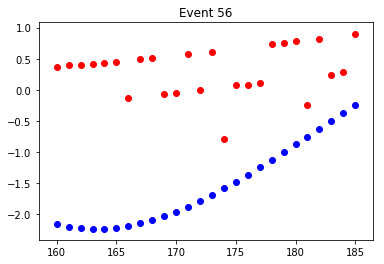

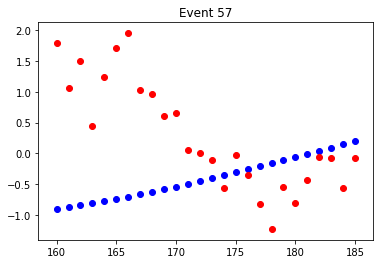

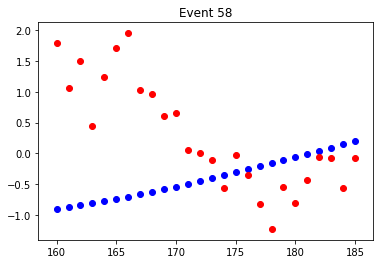

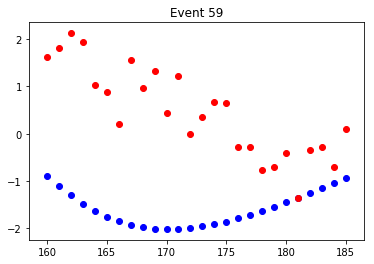

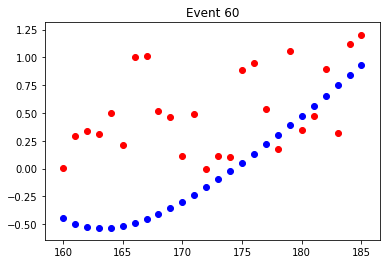

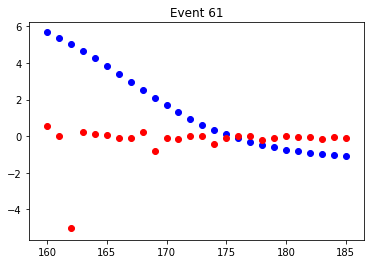

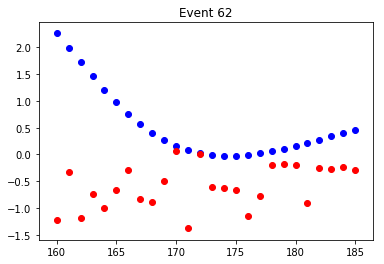

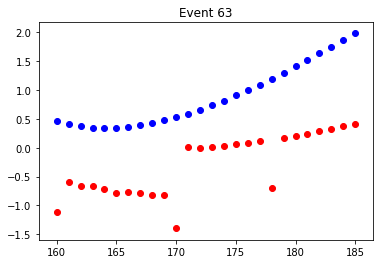

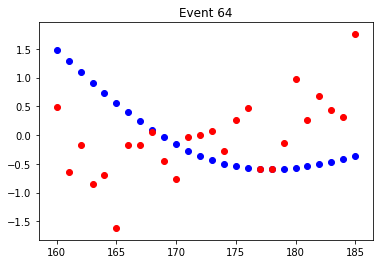

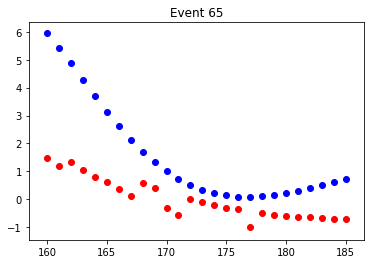

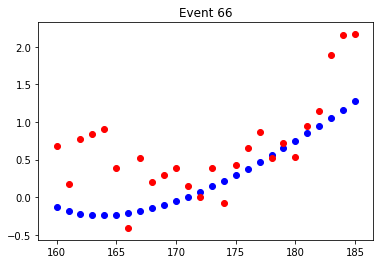

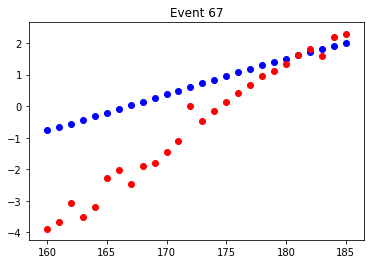

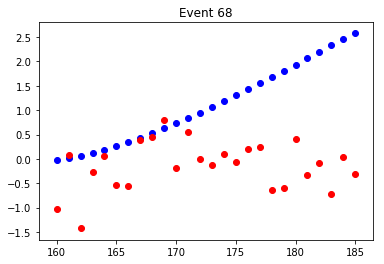

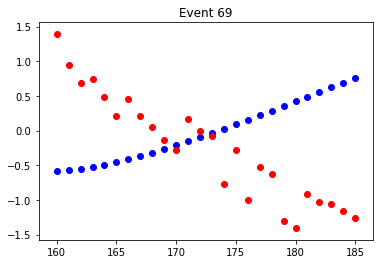

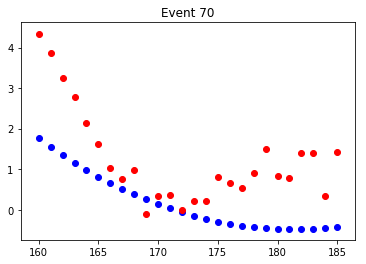

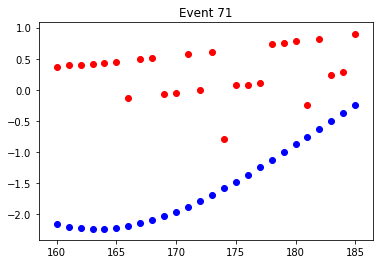

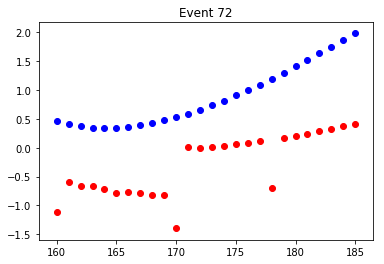

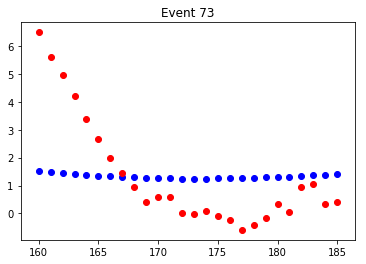

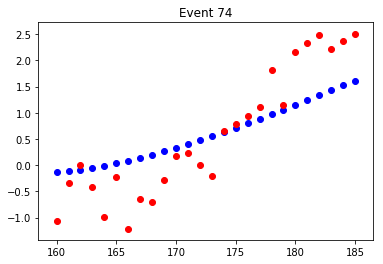

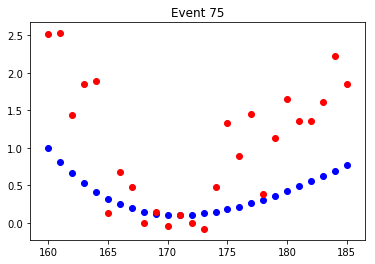

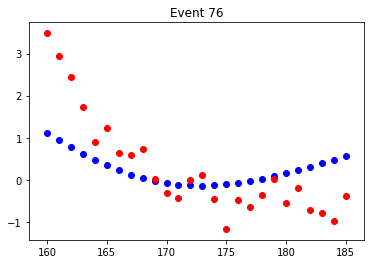

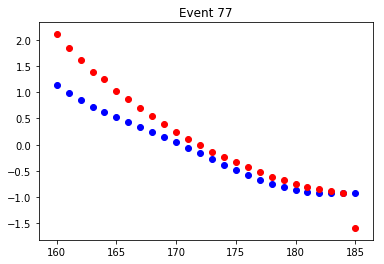

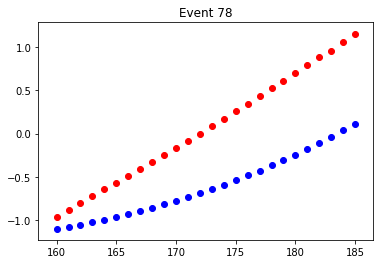

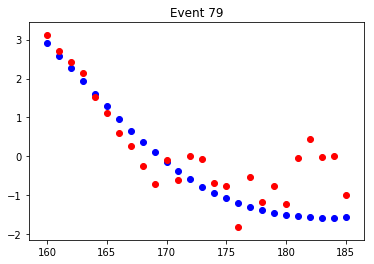

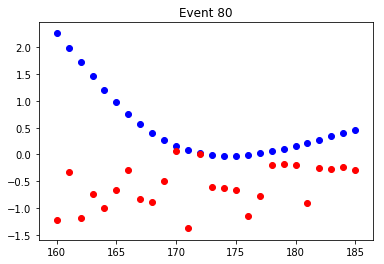

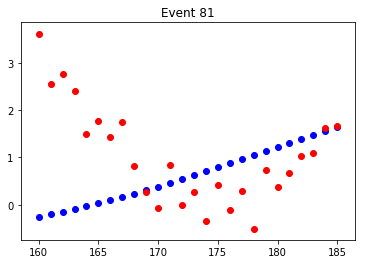

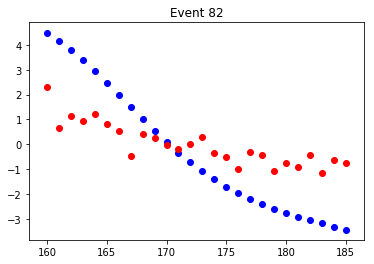

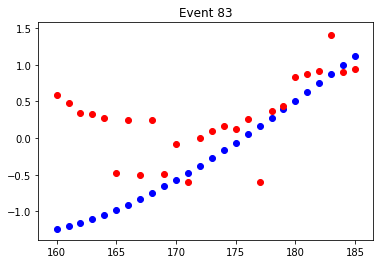

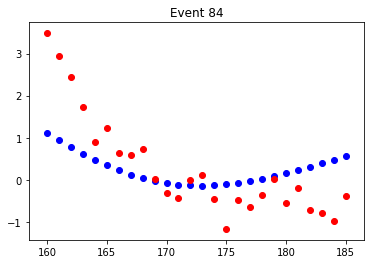

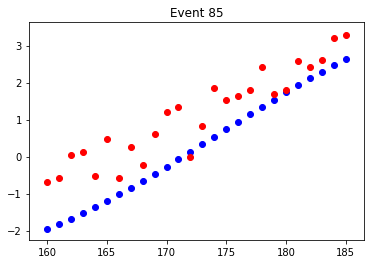

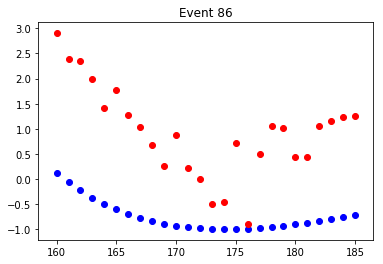

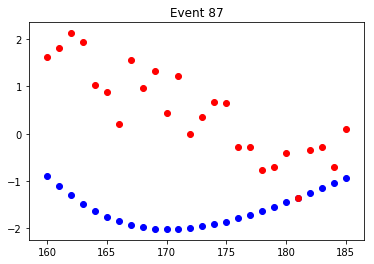

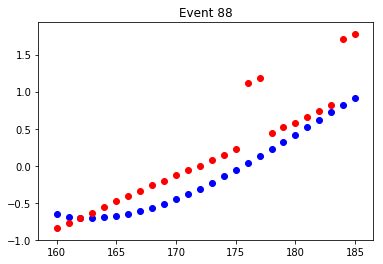

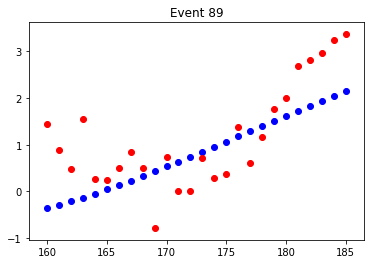

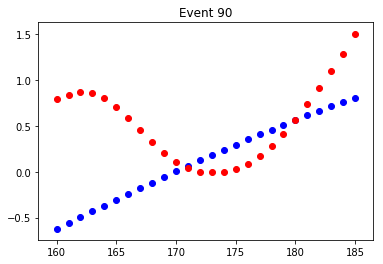

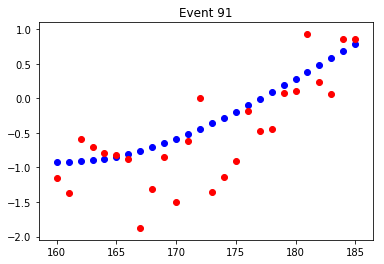

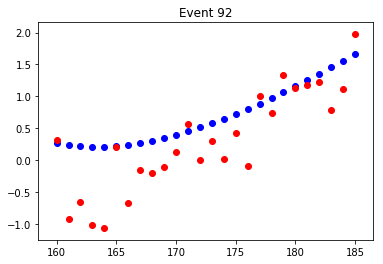

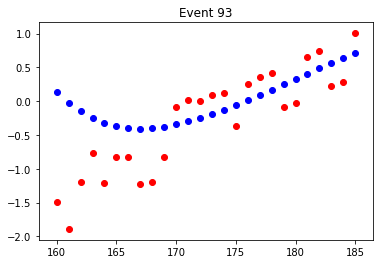

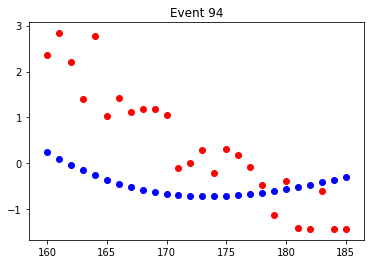

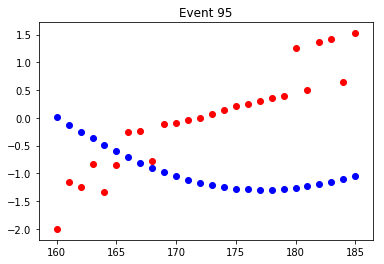

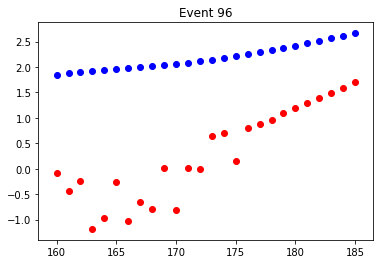

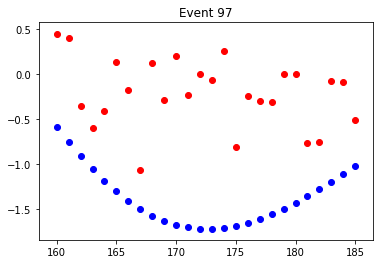

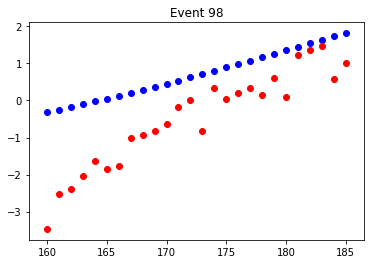

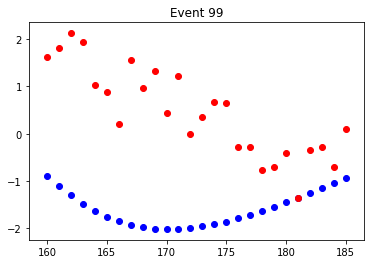

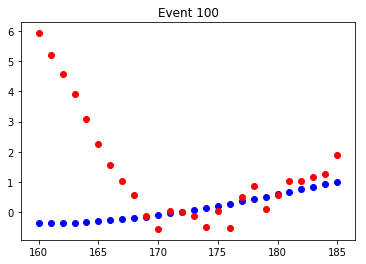

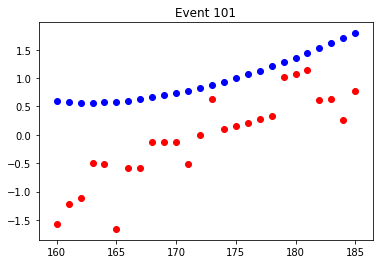

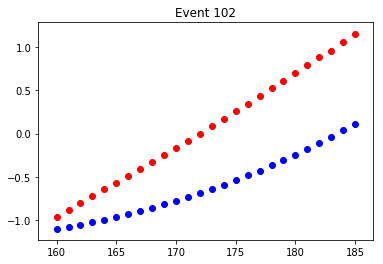

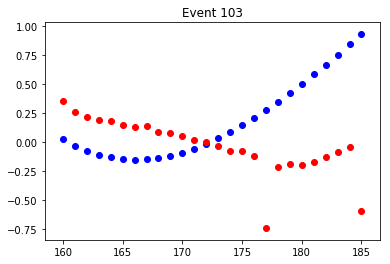

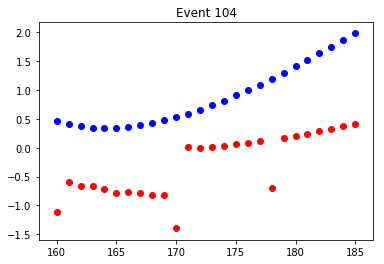

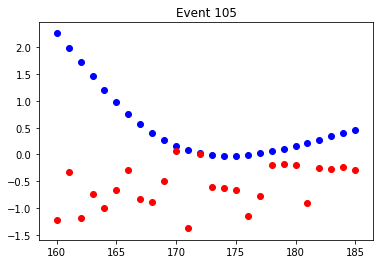

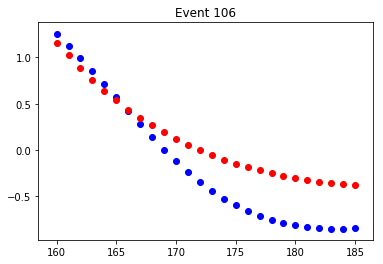

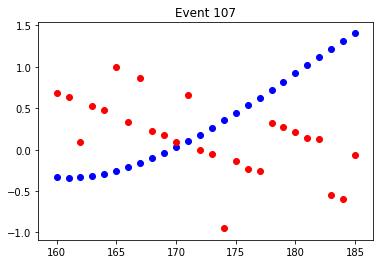

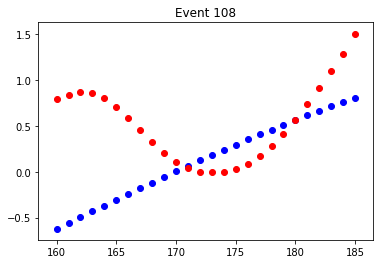

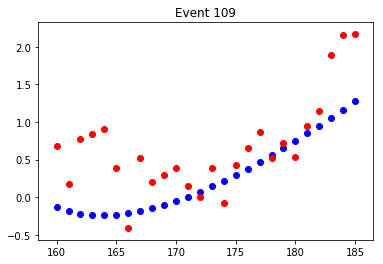

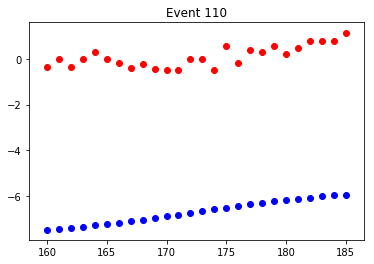

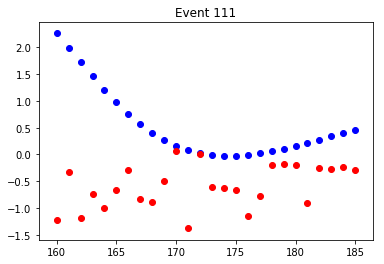

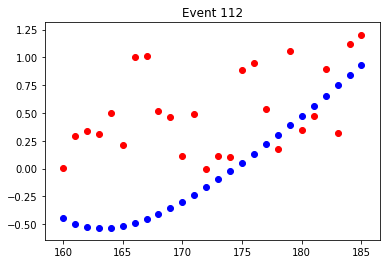

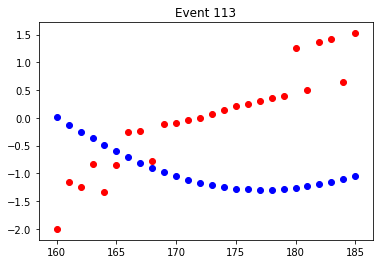

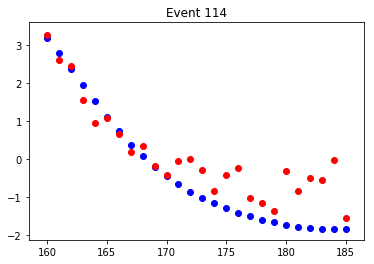

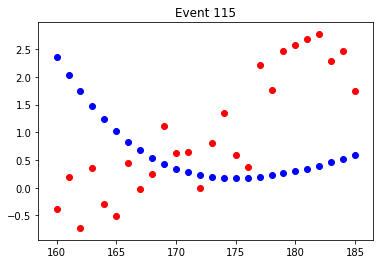

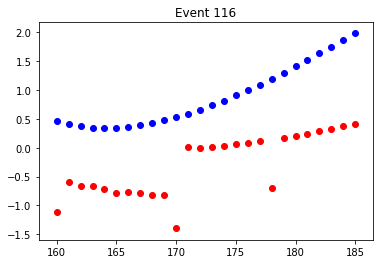

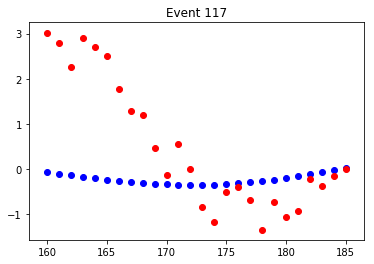

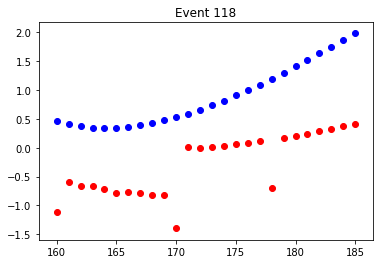

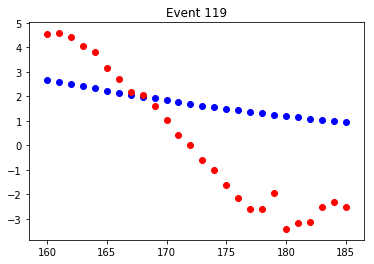

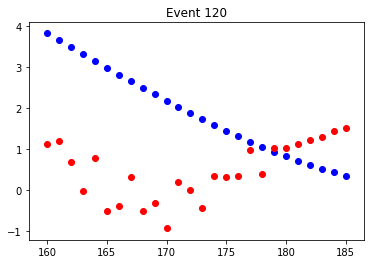

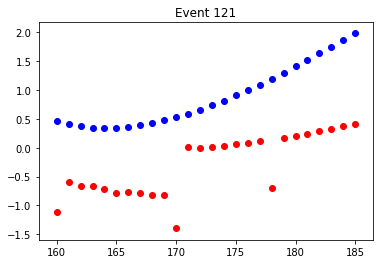

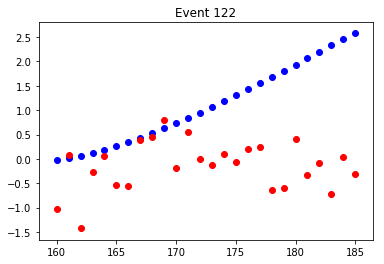

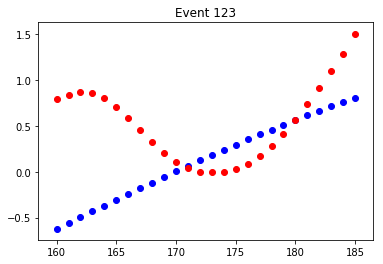

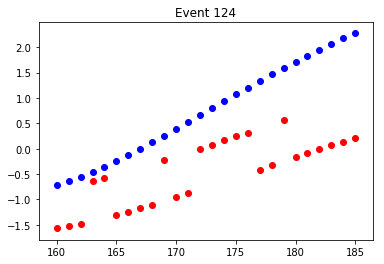

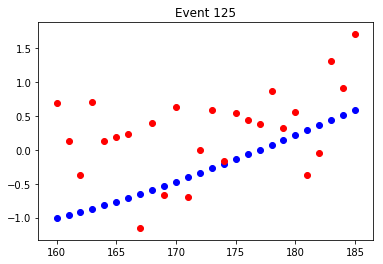

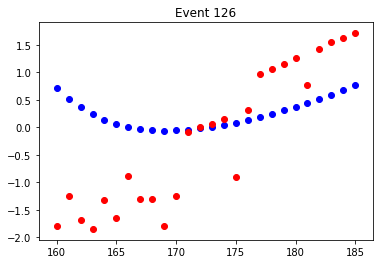

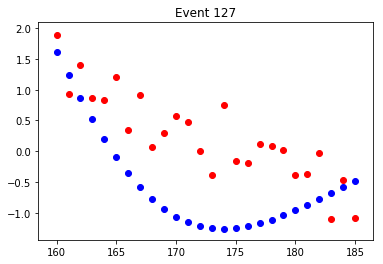

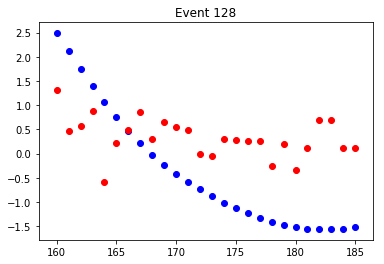

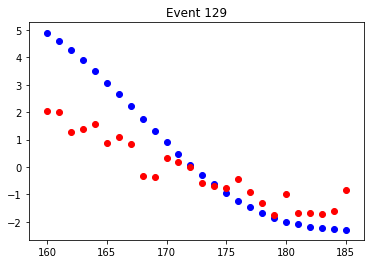

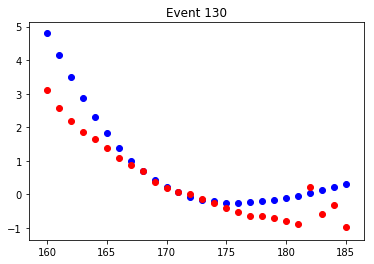

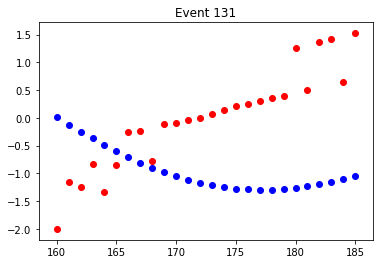

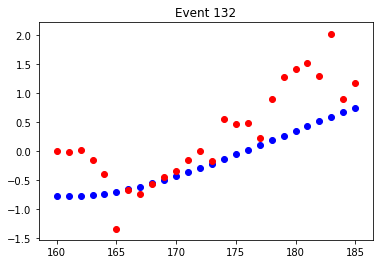

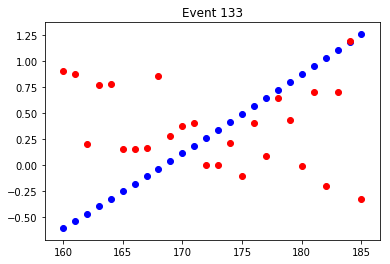

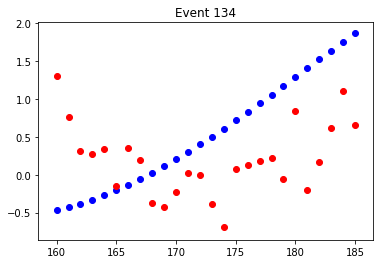

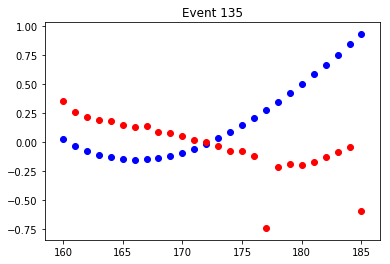

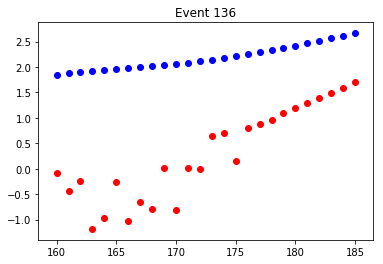

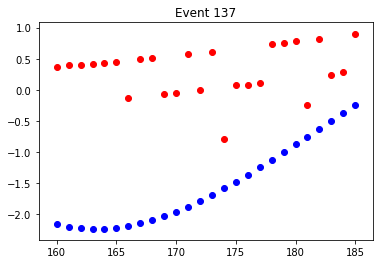

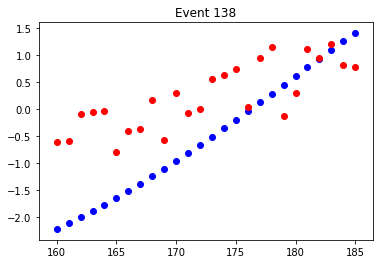

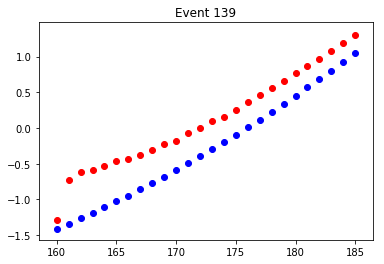

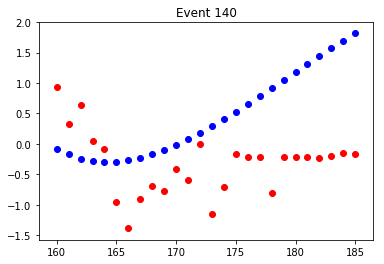

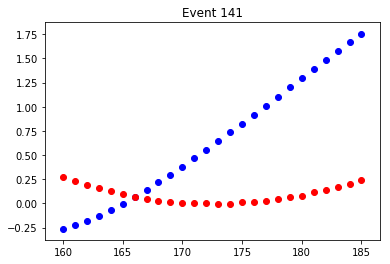

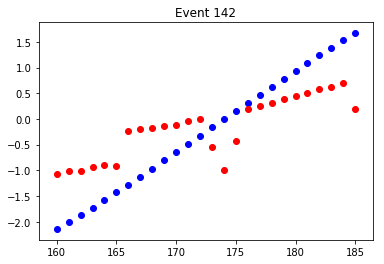

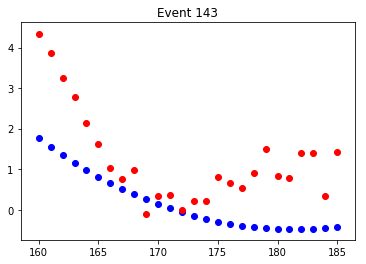

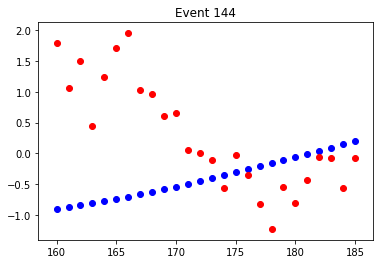

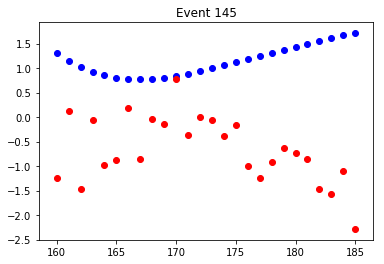

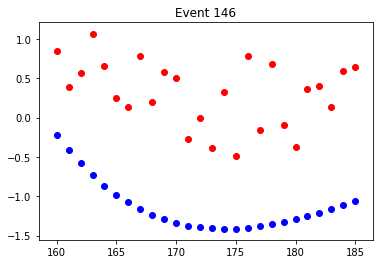

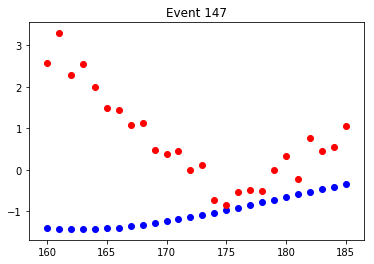

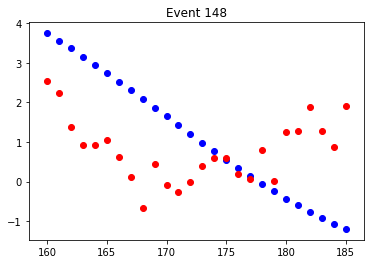

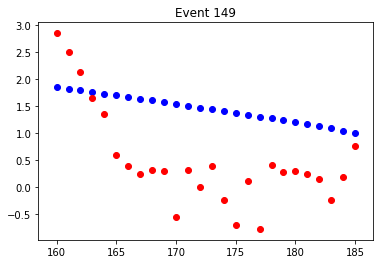

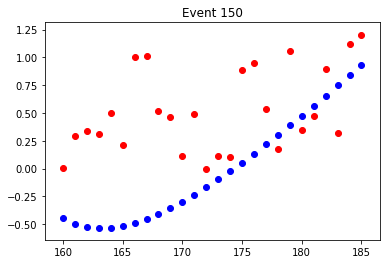

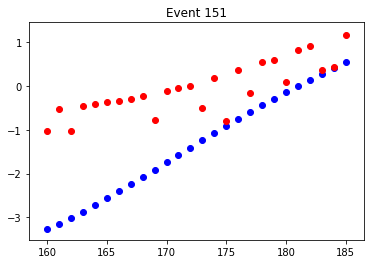

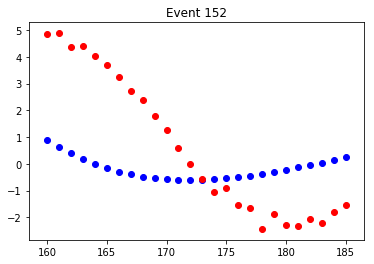

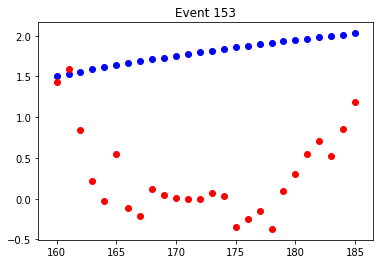

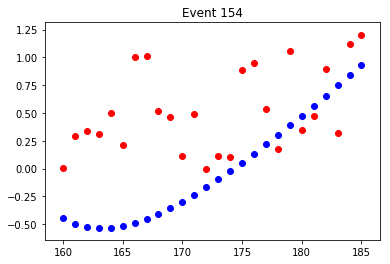

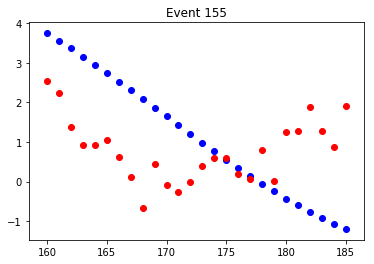

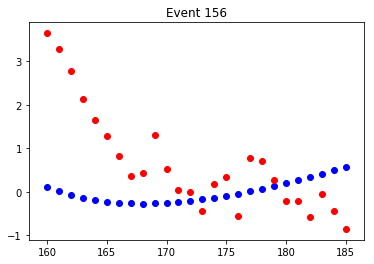

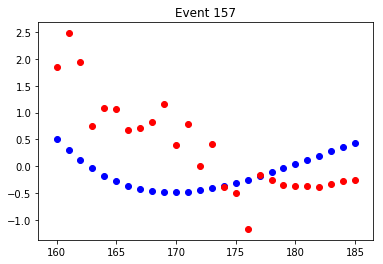

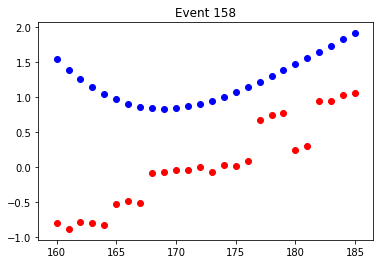

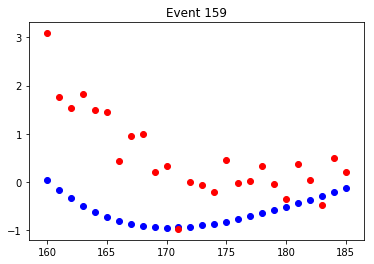

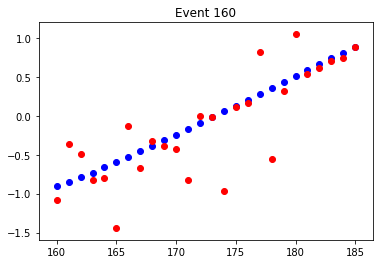

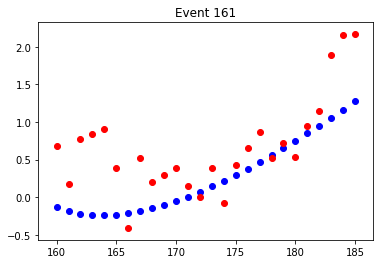

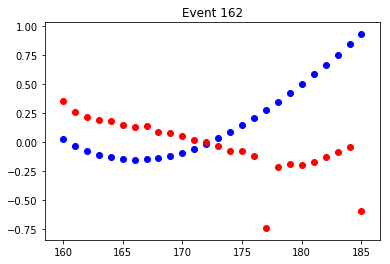

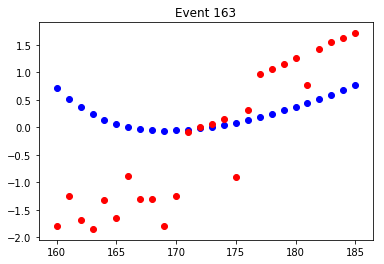

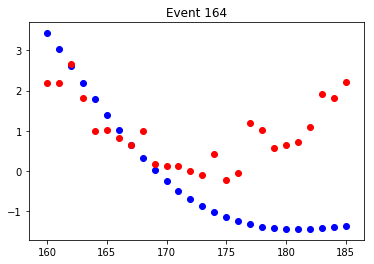

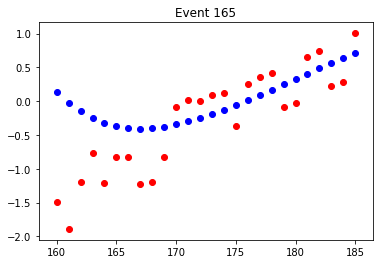

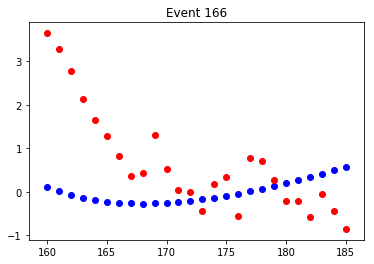

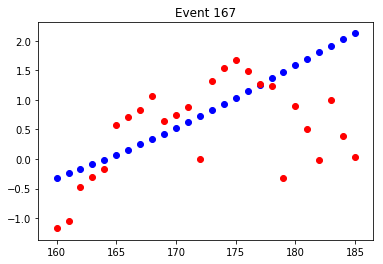

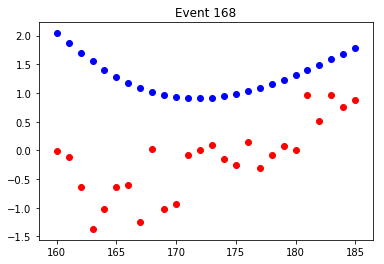

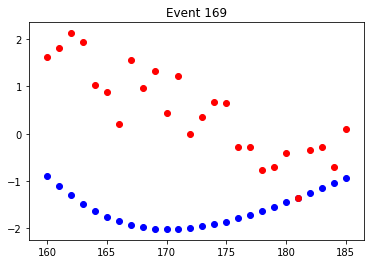

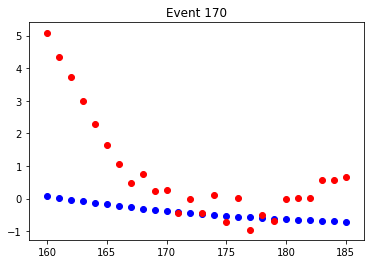

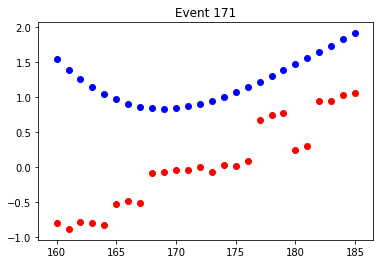

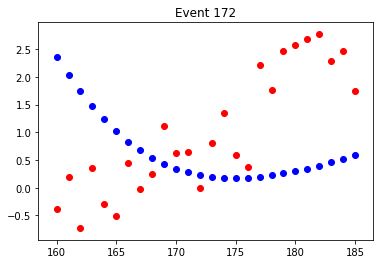

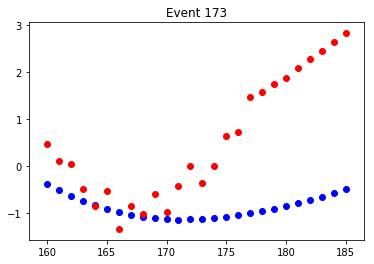

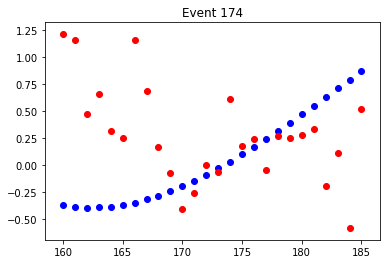

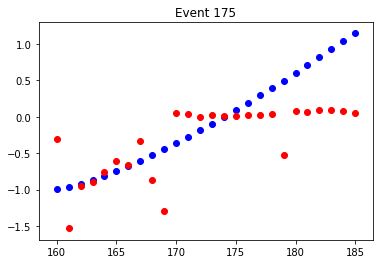

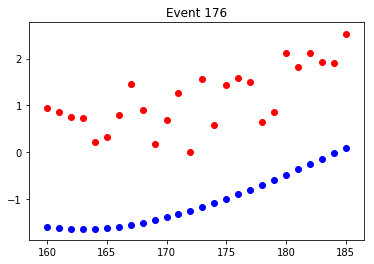

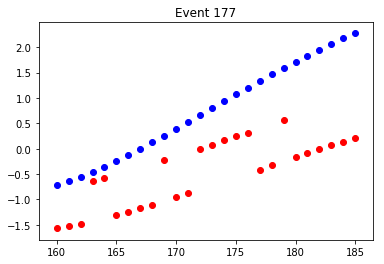

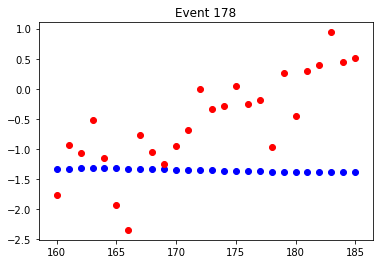

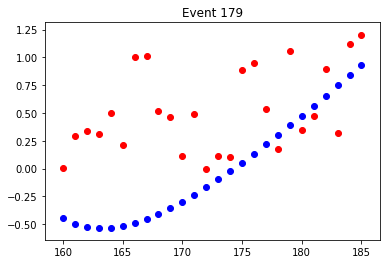

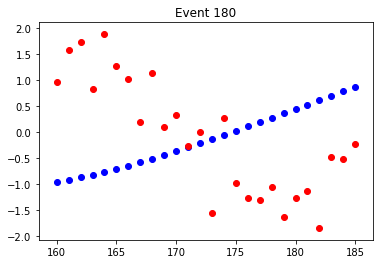

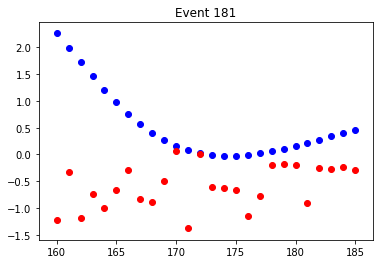

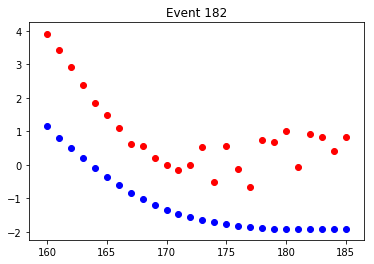

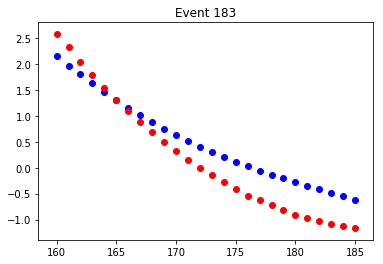

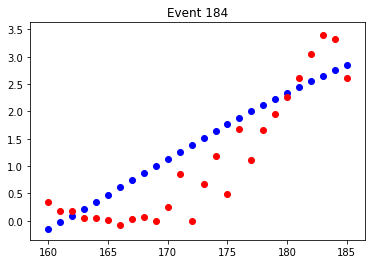

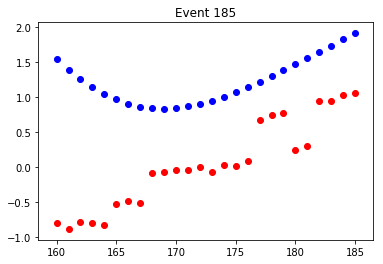

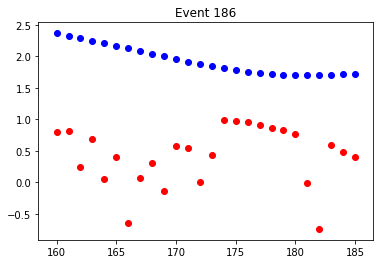

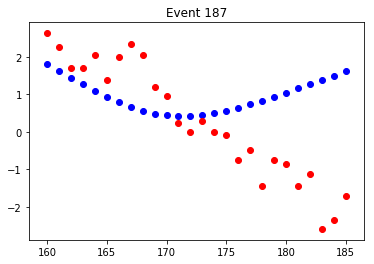

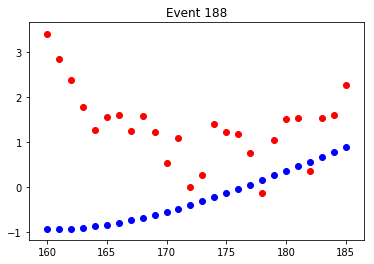

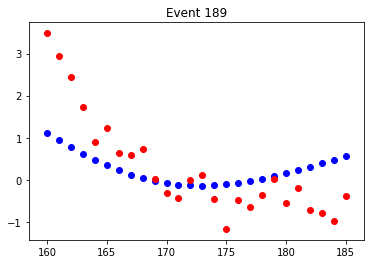

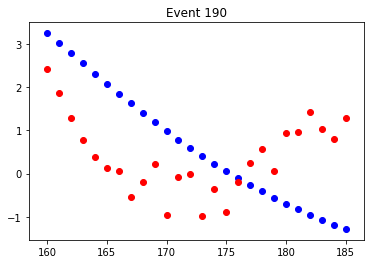

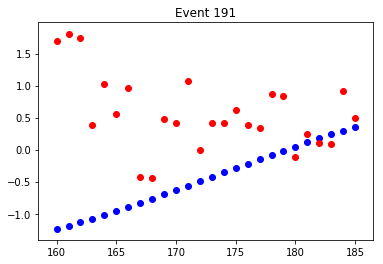

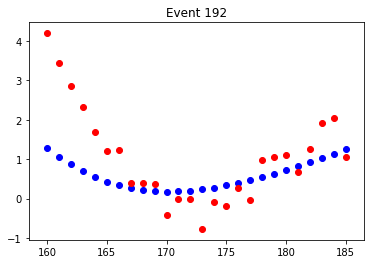

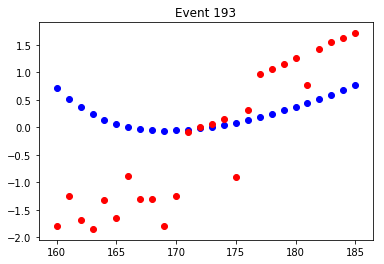

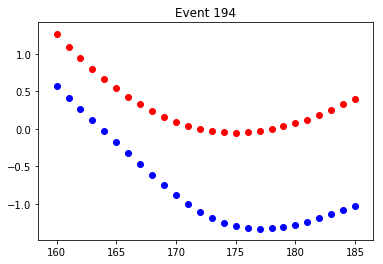

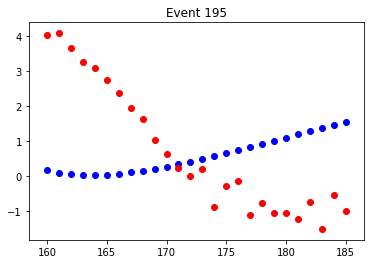

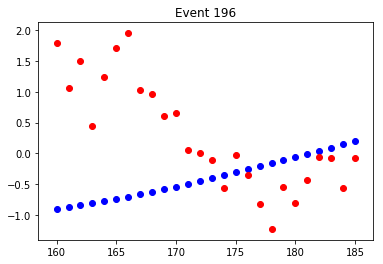

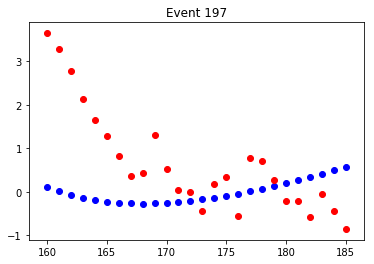

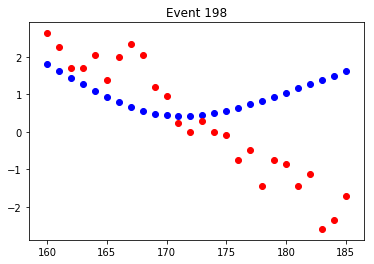

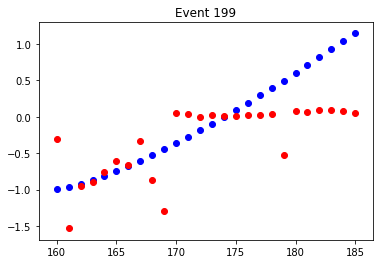

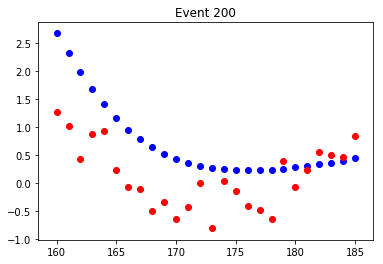

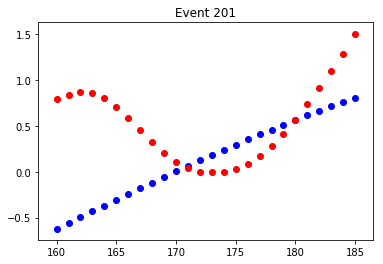

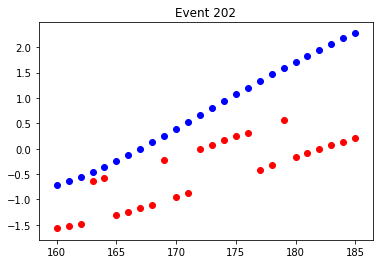

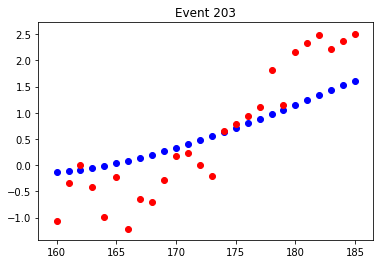

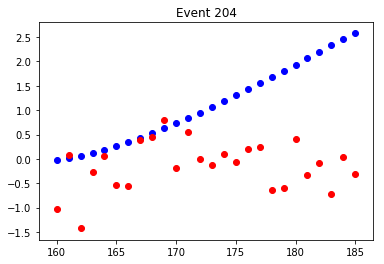

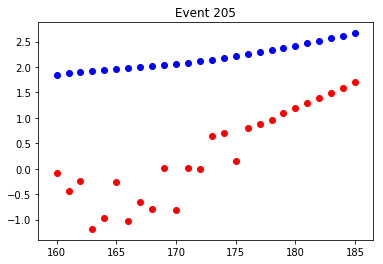

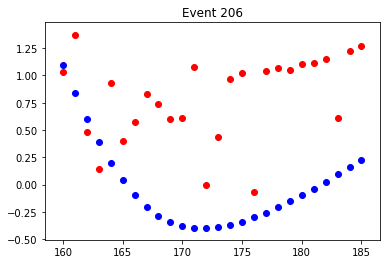

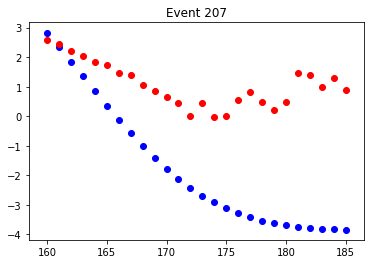

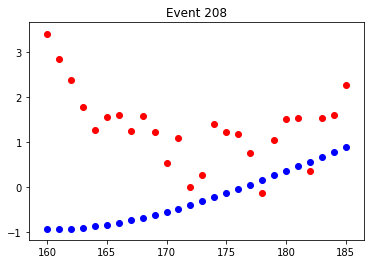

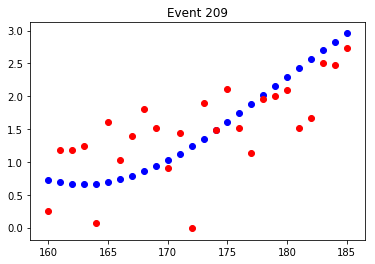

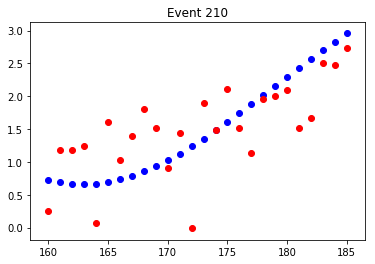

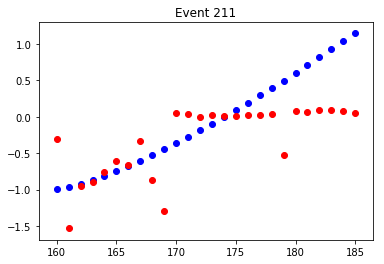

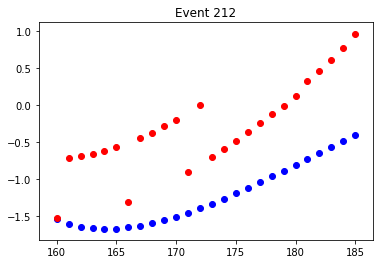

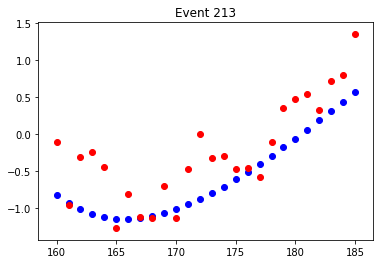

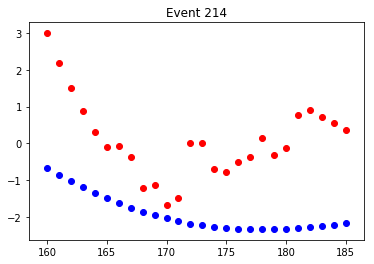

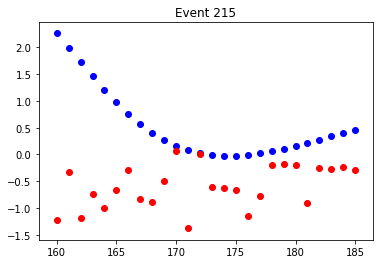

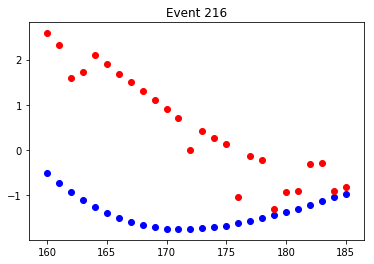

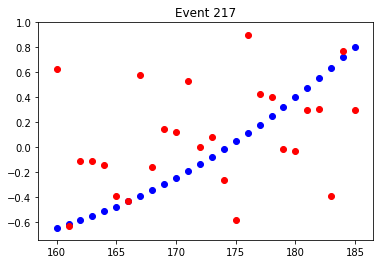

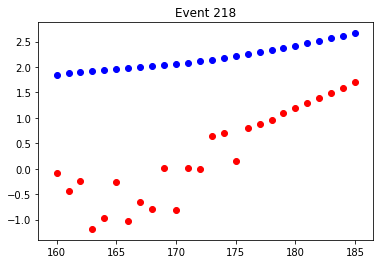

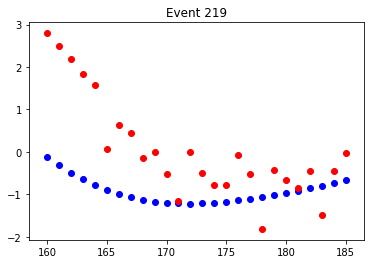

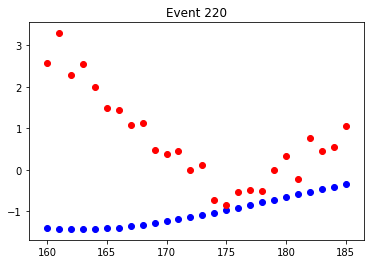

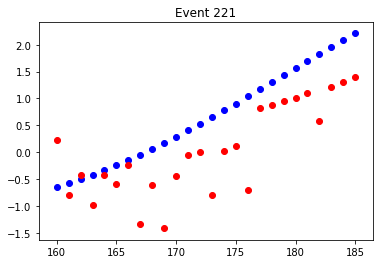

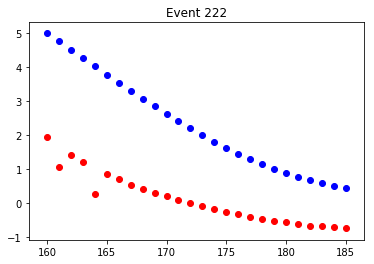

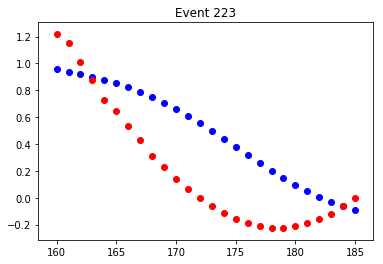

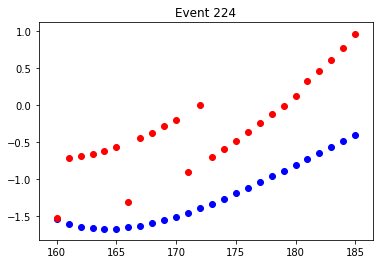

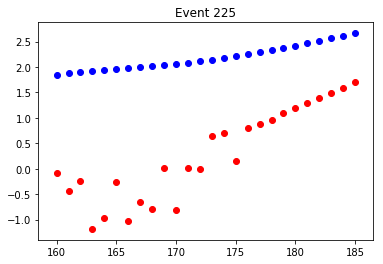

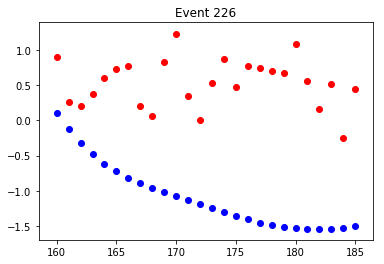

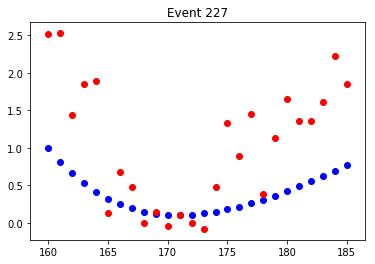

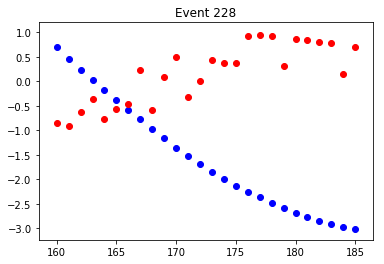

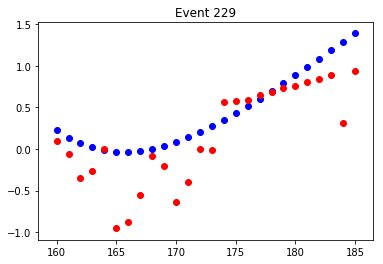

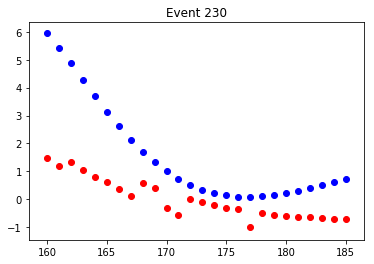

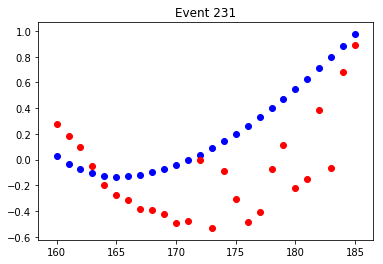

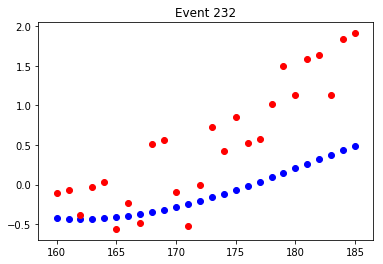

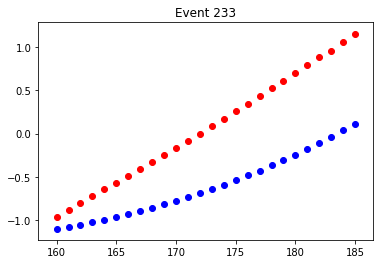

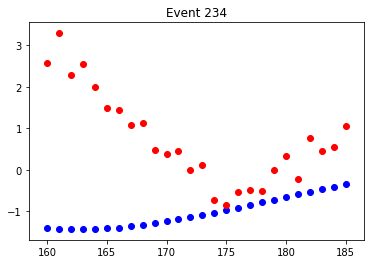

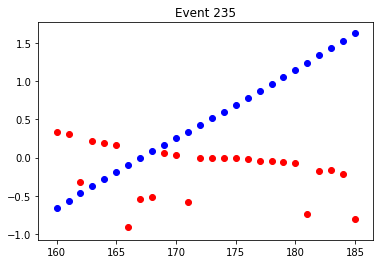

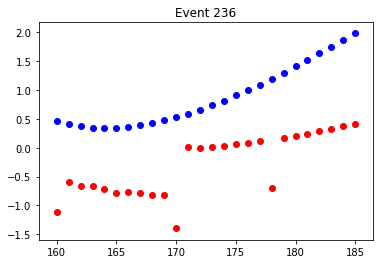

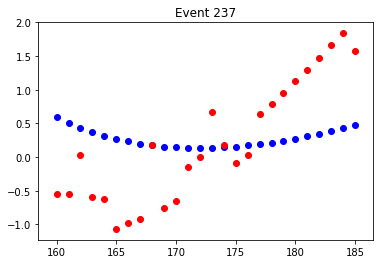

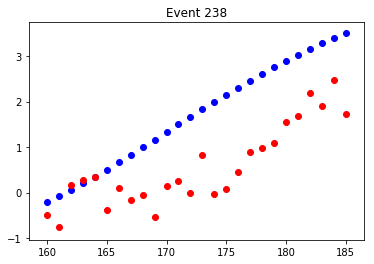

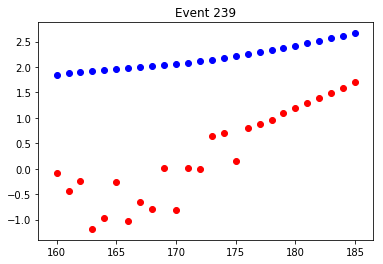

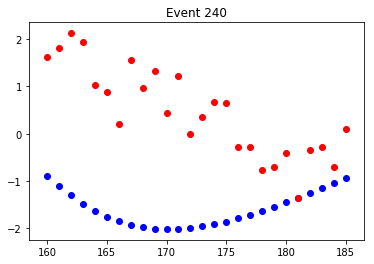

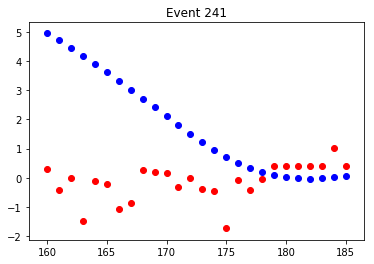

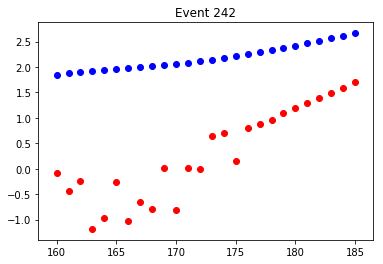

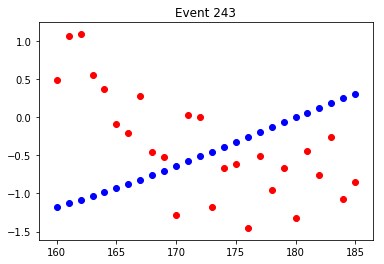

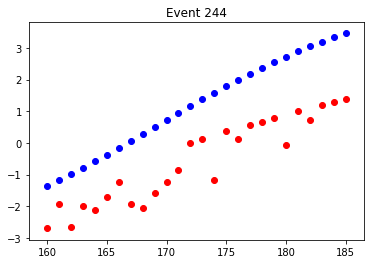

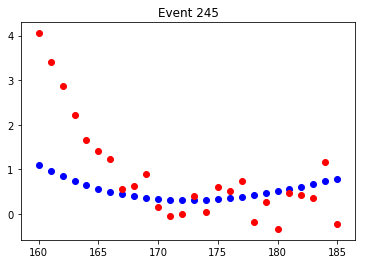

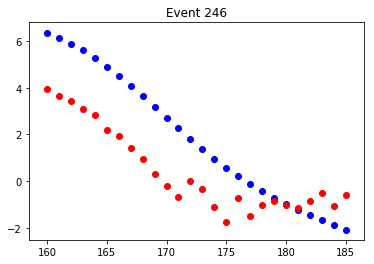

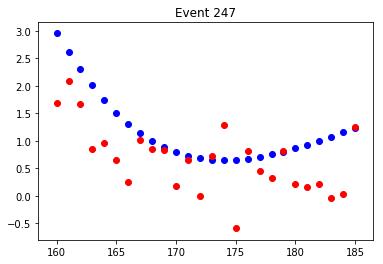

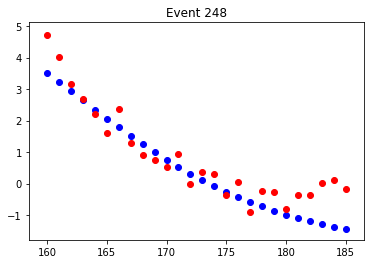

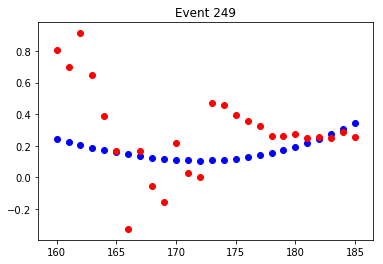

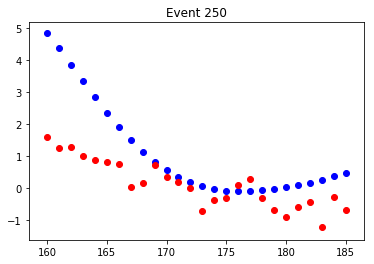

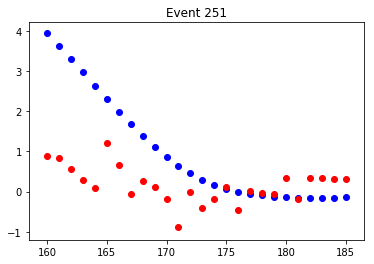

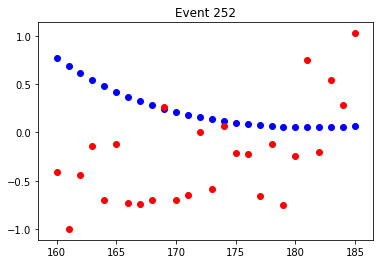

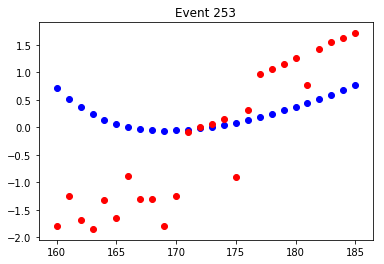

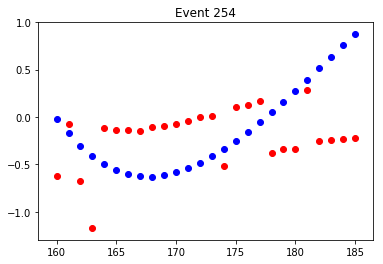

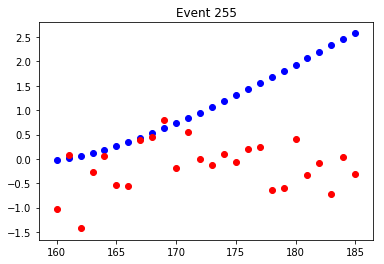

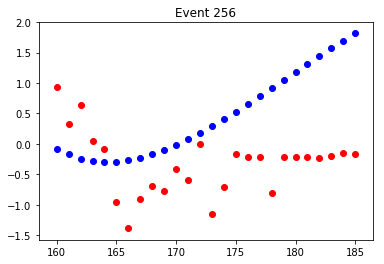

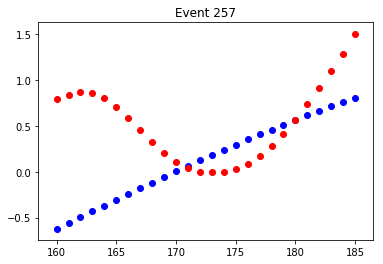

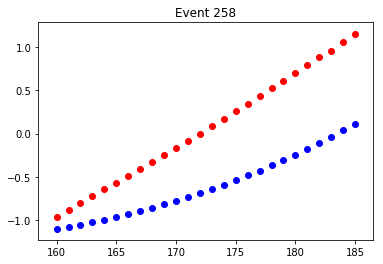

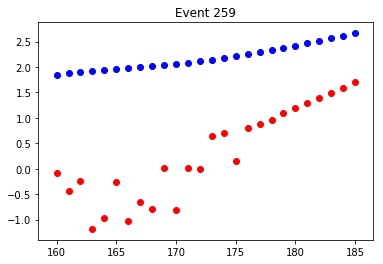

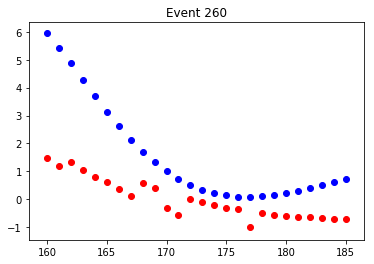

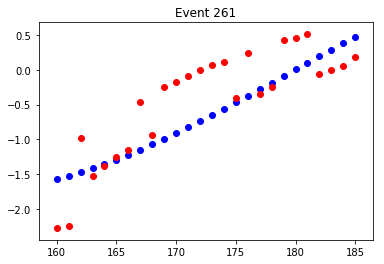

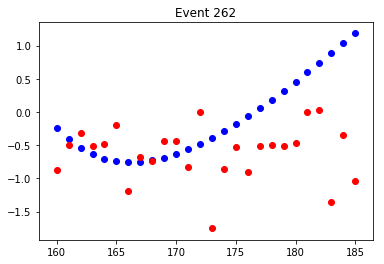

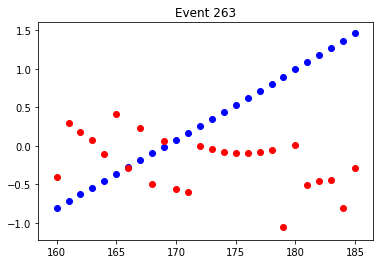

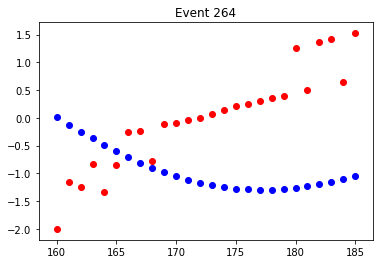

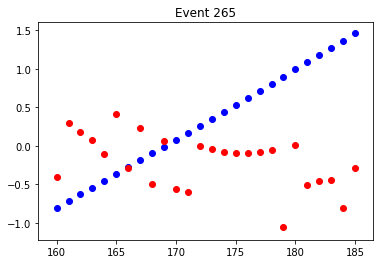

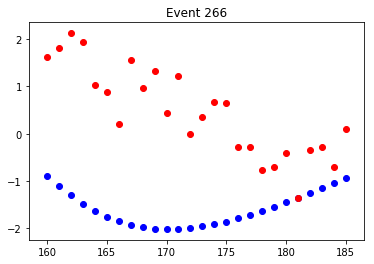

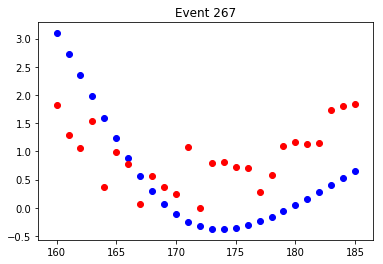

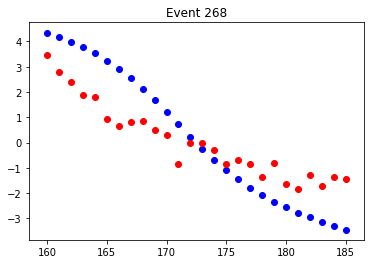

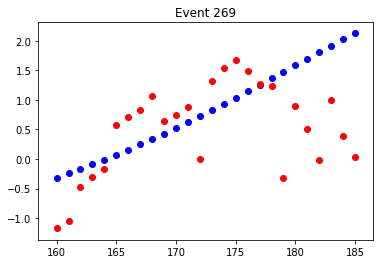

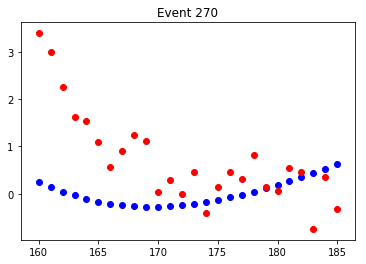

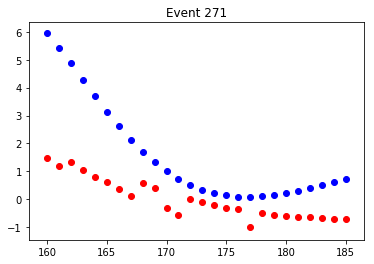

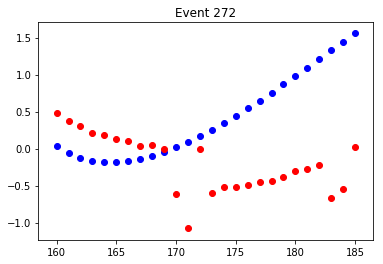

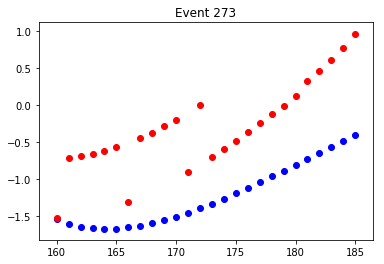

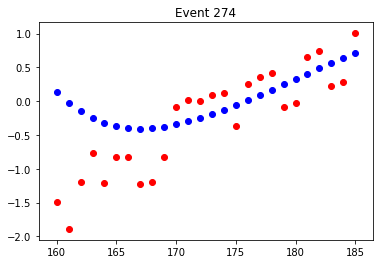

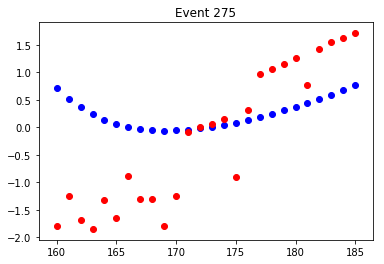

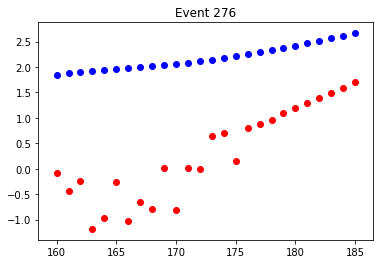

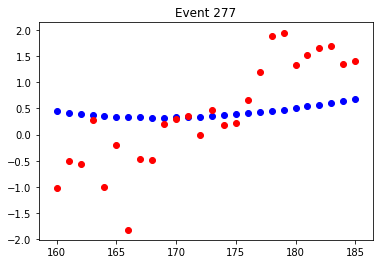

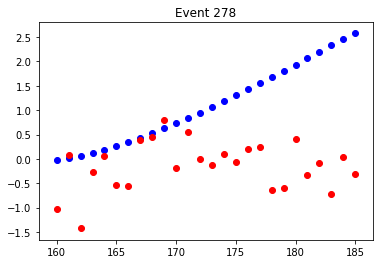

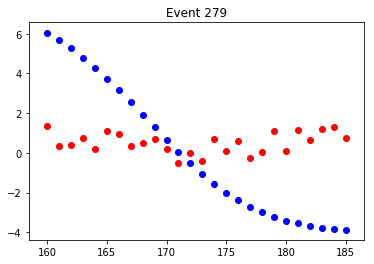

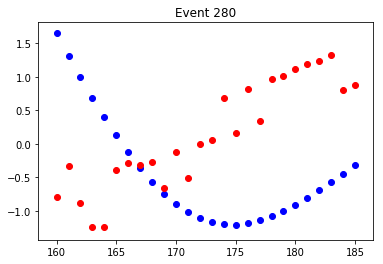

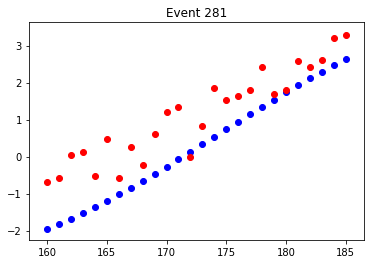

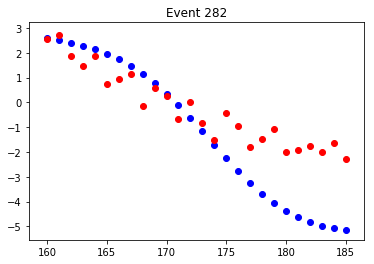

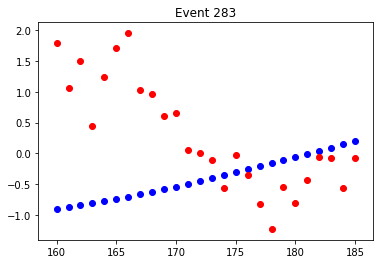

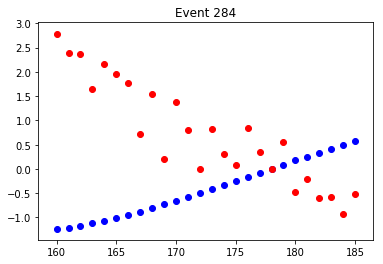

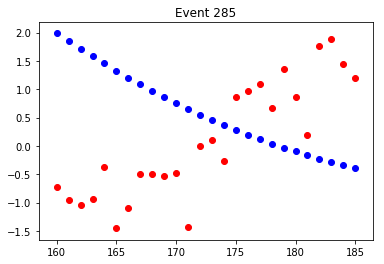

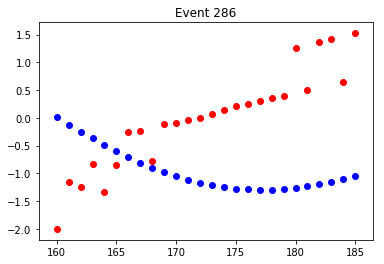

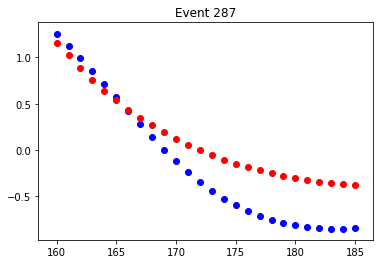

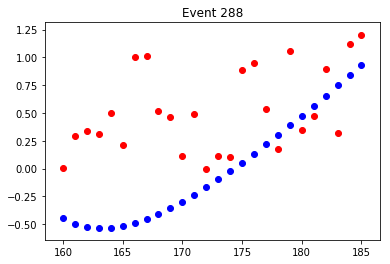

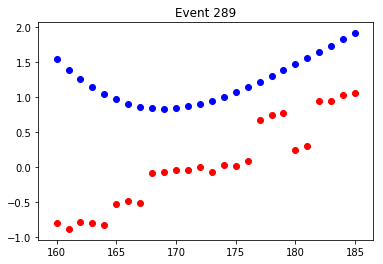

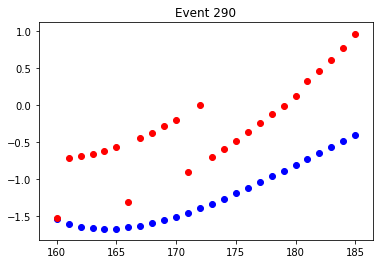

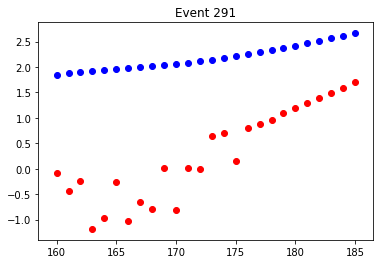

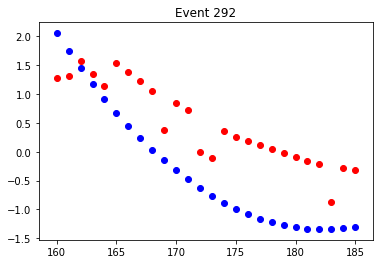

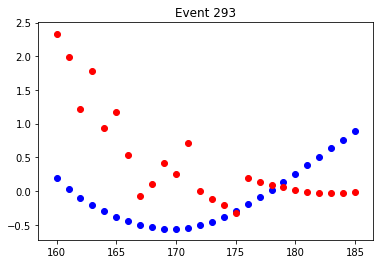

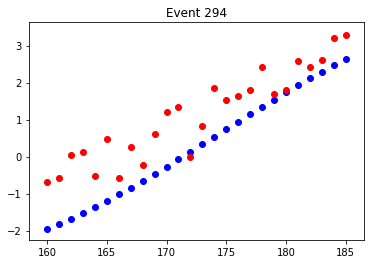

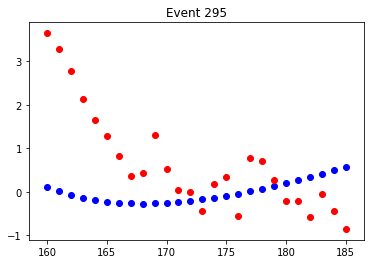

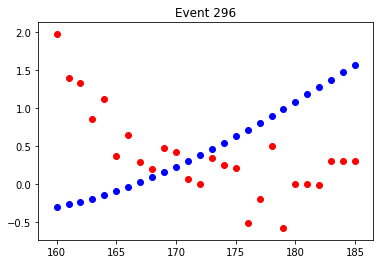

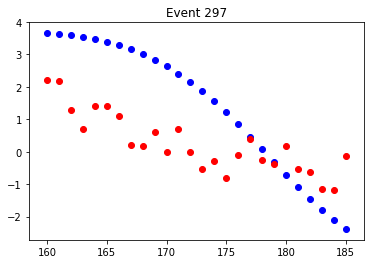

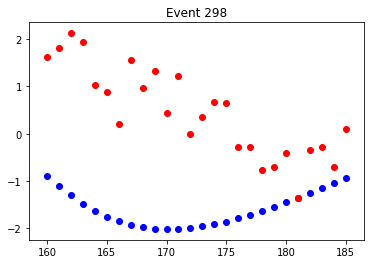

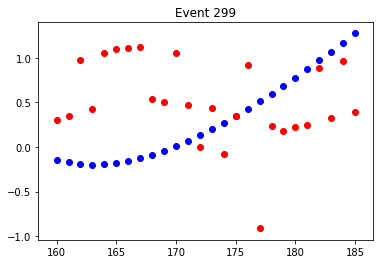

In [11]:
for i in range(0, n_events):
    plt.scatter(benchmarks, madminer_log_sq_ratios[i], marker='o', color='blue')
    plt.scatter(benchmarks, momemta_log_sq_ratios[i], marker='o', color='red')
    plt.title('Event {}'.format(i))
    plt.show()

### compare all events for each bechmark

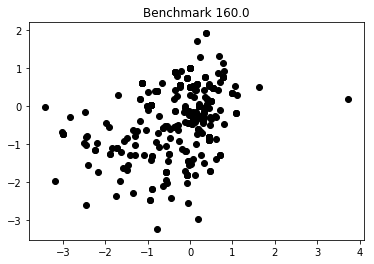

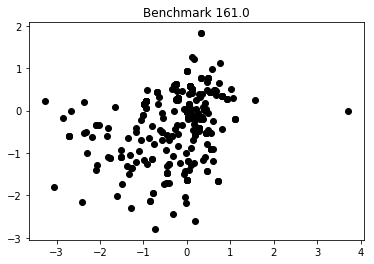

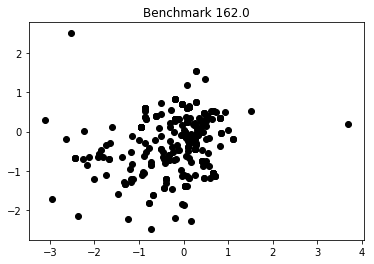

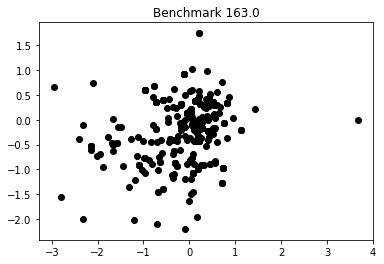

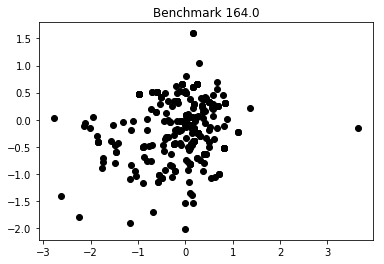

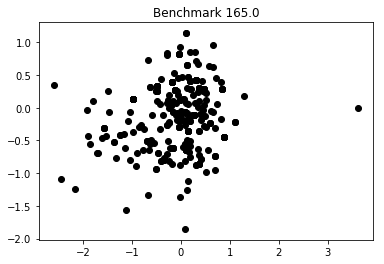

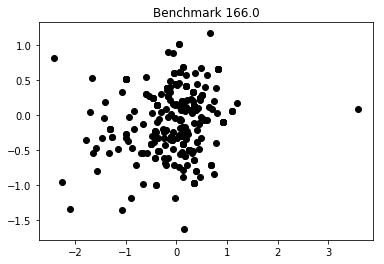

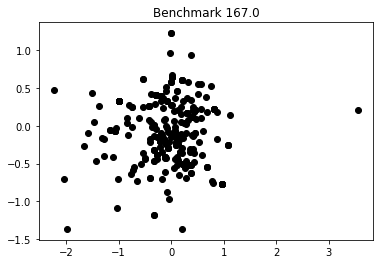

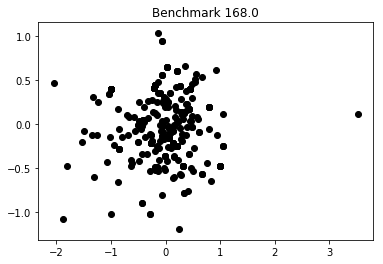

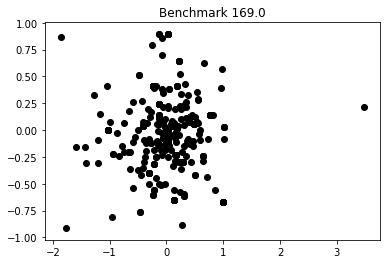

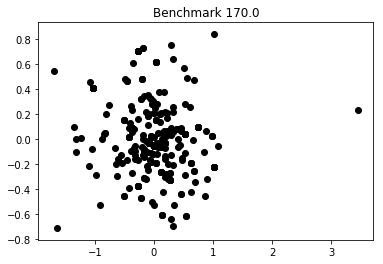

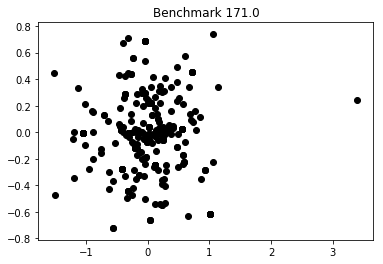

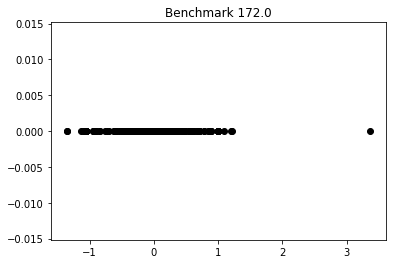

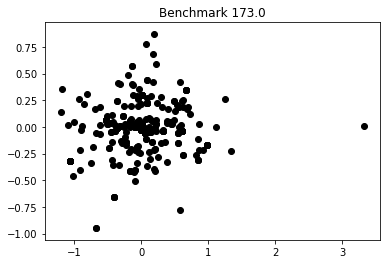

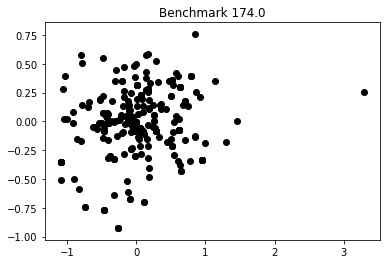

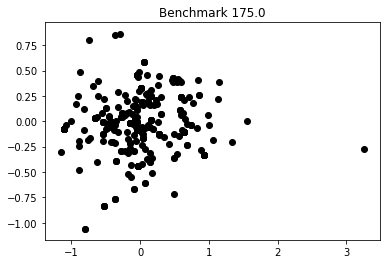

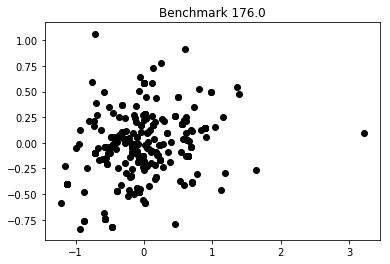

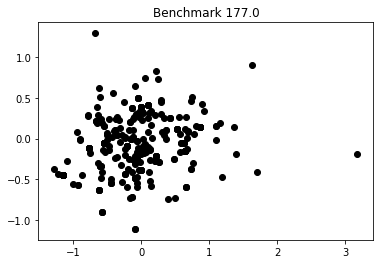

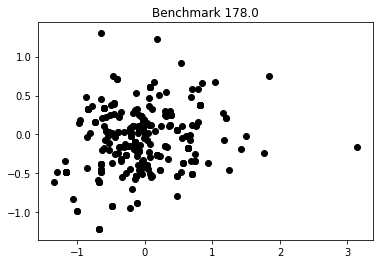

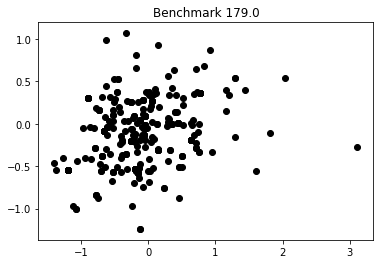

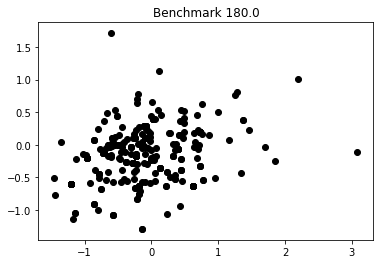

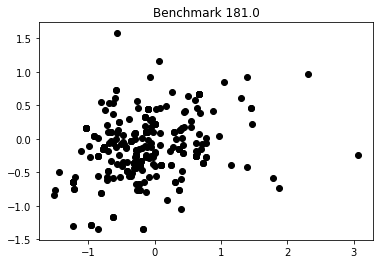

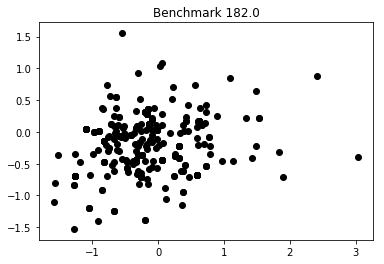

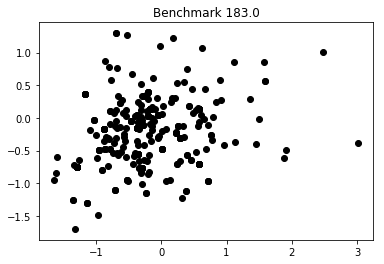

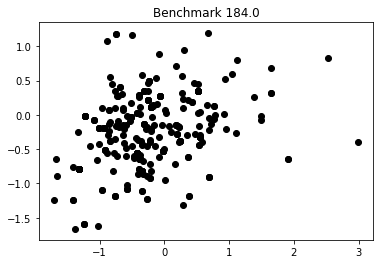

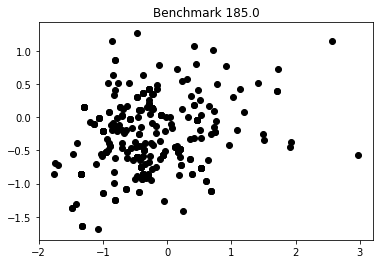

In [12]:
for i in range(0,madminer_log_ratios.shape[1]):
    plt.scatter(madminer_log_ratios[:,i], momemta_log_ratios[:,i], marker='o', color='black');
    plt.title('Benchmark {}'.format(benchmarks[i]))
    plt.show()

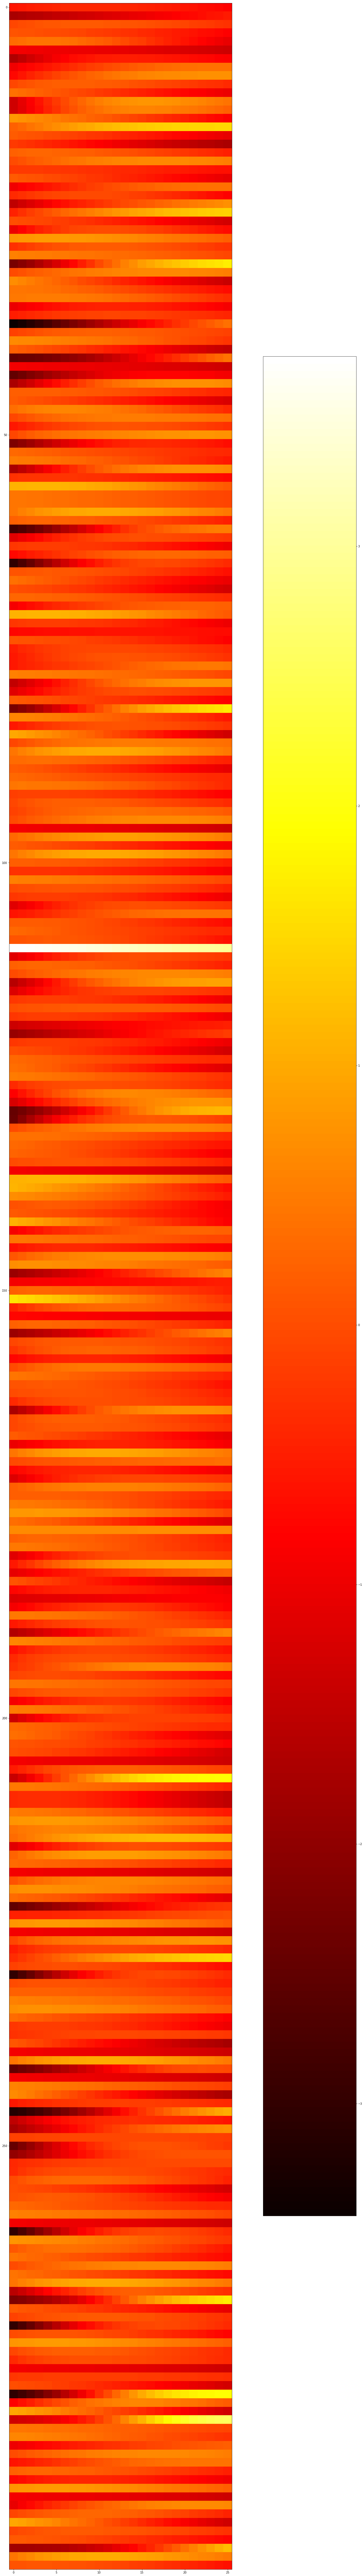

In [13]:
plt.figure(figsize=(40, 170))
plt.imshow(madminer_log_ratios, cmap='hot', interpolation='nearest')
plt.colorbar()


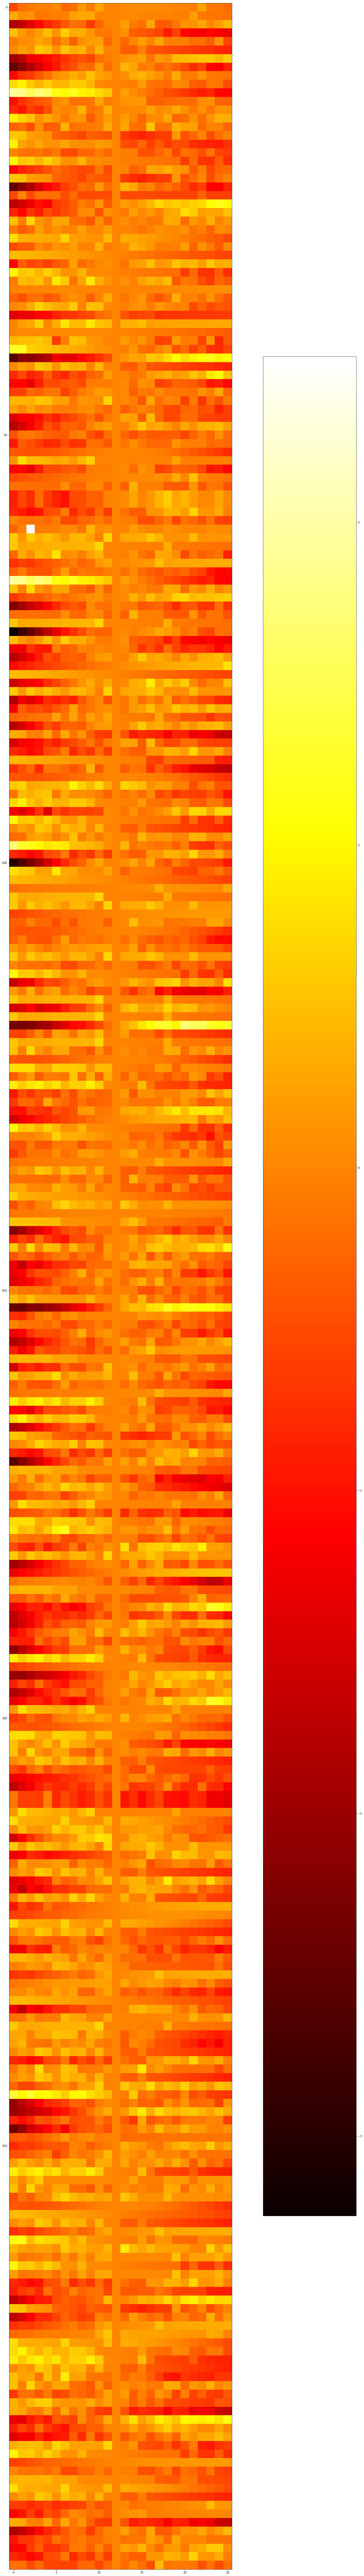

In [14]:
plt.figure(figsize=(40, 170))
plt.imshow(momemta_log_ratios, cmap='hot', interpolation='nearest')
plt.colorbar()